# **BUSINESS CASE 2: SIEMENS ADVANTA SALES FORECASTING**  


## 🎓 Master’s Program in Data Science & Advanced Analytics 
**Nova IMS** | March 2025   
**Course:** Business Cases with Data Science

## 👥 Team **Group A**  
- **Alice Viegas** | 20240572  
- **Bernardo Faria** | 20240579  
- **Dinis Pinto** | 20240612  
- **Daan van Holten** | 20240681
- **Philippe Dutranoit** | 20240518

## 📊 Goal of the notebook

In this notebook we make the build and test the models for forcasting. <br>

**Table of Contents** <br>
* [1. Initial Setup and DataLoading](#setup)
* [2. Predictions](#pred)
* [3. Export](#export)   

<hr>
<a class="anchor" id="setup">

 ## 1. Initial Setup and Data Loading
 </a>

In [90]:
import os
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
import itertools
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from prophet import Prophet
from statsmodels.tsa.statespace.sarimax import SARIMAX


from Model_Functions import *

import importlib
imported_module = importlib.import_module("Model_Functions")
importlib.reload(imported_module)


<module 'Model_Functions' from '/Users/philippedutranoit/document_ordi/nova/business_case_for_data_sciense/cases/BC_DA_Siemens/Notebooks/Model_Functions.py'>

In [91]:
sales_agg1 = pd.read_csv('../data/sales_agg1.csv').set_index('DATE')
sales_agg3 = pd.read_csv('../data/sales_agg3.csv').set_index('DATE')
sales_agg4 = pd.read_csv('../data/sales_agg4.csv').set_index('DATE')
sales_agg5 = pd.read_csv('../data/sales_agg5.csv').set_index('DATE')
sales_agg6 = pd.read_csv('../data/sales_agg6.csv').set_index('DATE')
sales_agg8 = pd.read_csv('../data/sales_agg8.csv').set_index('DATE')
sales_agg9 = pd.read_csv('../data/sales_agg9.csv').set_index('DATE')
sales_agg11 = pd.read_csv('../data/sales_agg11.csv').set_index('DATE')
sales_agg12 = pd.read_csv('../data/sales_agg12.csv').set_index('DATE')
sales_agg13 = pd.read_csv('../data/sales_agg13.csv').set_index('DATE')
sales_agg14 = pd.read_csv('../data/sales_agg14.csv').set_index('DATE')
sales_agg16 = pd.read_csv('../data/sales_agg16.csv').set_index('DATE')
sales_agg20 = pd.read_csv('../data/sales_agg20.csv').set_index('DATE')
sales_agg36 = pd.read_csv('../data/sales_agg36.csv').set_index('DATE')

# extract the selected features list build in the feature selection step
selected_features_1 = pd.read_csv('../data/selected_features_1.csv')['selected_features'].tolist()
selected_features_3 = pd.read_csv('../data/selected_features_3.csv')['selected_features'].tolist()
selected_features_4 = pd.read_csv('../data/selected_features_4.csv')['selected_features'].tolist()
selected_features_5 = pd.read_csv('../data/selected_features_5.csv')['selected_features'].tolist()
selected_features_6 = pd.read_csv('../data/selected_features_6.csv')['selected_features'].tolist()
selected_features_8 = pd.read_csv('../data/selected_features_8.csv')['selected_features'].tolist()
selected_features_9 = pd.read_csv('../data/selected_features_9.csv')['selected_features'].tolist()
selected_features_11 = pd.read_csv('../data/selected_features_11.csv')['selected_features'].tolist()
selected_features_12 = pd.read_csv('../data/selected_features_12.csv')['selected_features'].tolist()
selected_features_13 = pd.read_csv('../data/selected_features_13.csv')['selected_features'].tolist()
selected_features_14 = pd.read_csv('../data/selected_features_14.csv')['selected_features'].tolist()
selected_features_16 = pd.read_csv('../data/selected_features_16.csv')['selected_features'].tolist()
selected_features_20 = pd.read_csv('../data/selected_features_20.csv')['selected_features'].tolist()
selected_features_36 = pd.read_csv('../data/selected_features_36.csv')['selected_features'].tolist()


# load the market data
df_market = pd.read_csv('../data/Market_data_predicted.csv').set_index('date')
test_set = pd.read_csv('../Data/Case2_Test Set Template.csv', sep=';')
print(sales_agg1.head())
df_market.head()


               Sales_EUR
DATE                    
2018-10-01  3.609892e+07
2018-11-01  3.699427e+07
2018-12-01  3.788961e+07
2019-01-01  2.772815e+07
2019-02-01  3.479316e+07


,MAB_ELE_PRO156,MAB_ELE_SHP156,MAB_ELE_SHP250,MAB_ELE_PRO392,MAB_ELE_SHP392,MAB_ELE_PRO756,MAB_ELE_SHP756,MAB_ELE_PRO826,MAB_ELE_SHP826,MAB_ELE_SHP840,...,PRI27380_org,PRI27250_org,PRI27276_org,PRO28756_org,PRO28392_org,PRO271000_org,PRO27756_org,PRO27826_org,PRO27392_org,PRO27276_org
date,,,,,,,,,,,,,,,,,,,,,
2004-02-01,16.940704,16.940704,83.458866,109.334010,110.495272,86.074496,80.962532,111.353812,77.766367,90.442749,...,93.020027,96.864647,93.230453,96.177481,110.890034,91.390440,68.677657,120.706516,106.161262,85.913200
2004-03-01,23.711852,23.711852,106.168192,140.884616,144.686166,86.038258,80.912352,127.558608,77.829225,90.580357,...,93.540268,96.864653,93.335678,96.250927,141.176853,91.511498,68.452548,138.309550,140.288741,97.670815
2004-04-01,24.435235,24.435235,92.007646,105.853579,102.655769,85.997063,80.857863,108.732297,77.904642,90.751805,...,93.852425,96.864659,93.440903,96.330211,105.648765,91.666790,68.203892,115.557330,106.271197,87.253983
2004-05-01,23.708115,23.708115,85.696486,101.864777,100.305285,85.951483,80.800601,110.645200,77.993606,90.961426,...,93.852425,96.864666,93.546127,96.413549,101.990361,91.861457,67.936322,119.269534,101.608710,84.675552
2004-06-01,27.009138,27.009138,106.641482,120.332920,119.616380,85.902640,80.742724,122.020960,78.096995,91.213203,...,93.956467,96.864672,93.440903,96.499291,122.136575,92.100289,67.655734,128.849416,116.655248,95.401802


In [92]:
def parse_month_year(date_string):
    month_map = {
    "Jan": 1,
    "Feb": 2,
    "Mai": 5,
    "Jun": 6,
    "Jul": 7,
    "Aug": 8,
    "Sep": 9,
    "Okt": 10,
    "Nov": 11,
    "Dez": 12
    }

    month_abbr = date_string[:3]
    year_suffix = date_string[-2:]
    month_num = month_map.get(month_abbr)

    if not month_num:
        raise ValueError(f"Unknown month abbreviation: {month_abbr}")
    
    return datetime.strptime(f"{month_num} 01 {year_suffix}", "%m %d %y").date()
# Apply conversion safely
test_set['Month Year'] = test_set['Month Year'].apply(parse_month_year)

<hr>
<a class="anchor" id="pred">

 ## 2. Predictions
 </a>

## Create the lag market data feature needed for the model

In [93]:
df_market = create_lag_features(df_market, 6)
df_market.head()

/Users/philippedutranoit/document_ordi/nova/business_case_for_data_sciense/cases/BC_DA_Siemens/Notebooks/Model_Functions.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_lagging[f'{col}_lag_{lag}'] = df_lagging[col].shift(lag)
/Users/philippedutranoit/document_ordi/nova/business_case_for_data_sciense/cases/BC_DA_Siemens/Notebooks/Model_Functions.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_lagging[f'{col}_lag_{lag}'] = df_lagging[col].shift(lag)
/Users/philippedutranoit/document_ordi/nova/business_case_for_data

,MAB_ELE_PRO156,MAB_ELE_SHP156,MAB_ELE_SHP250,MAB_ELE_PRO392,MAB_ELE_SHP392,MAB_ELE_PRO756,MAB_ELE_SHP756,MAB_ELE_PRO826,MAB_ELE_SHP826,MAB_ELE_SHP840,...,PRI27380_org_lag_6,PRI27250_org_lag_6,PRI27276_org_lag_6,PRO28756_org_lag_6,PRO28392_org_lag_6,PRO271000_org_lag_6,PRO27756_org_lag_6,PRO27826_org_lag_6,PRO27392_org_lag_6,PRO27276_org_lag_6
date,,,,,,,,,,,,,,,,,,,,,
2004-02-01,16.940704,16.940704,83.458866,109.334010,110.495272,86.074496,80.962532,111.353812,77.766367,90.442749,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-03-01,23.711852,23.711852,106.168192,140.884616,144.686166,86.038258,80.912352,127.558608,77.829225,90.580357,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-04-01,24.435235,24.435235,92.007646,105.853579,102.655769,85.997063,80.857863,108.732297,77.904642,90.751805,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-05-01,23.708115,23.708115,85.696486,101.864777,100.305285,85.951483,80.800601,110.645200,77.993606,90.961426,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-06-01,27.009138,27.009138,106.641482,120.332920,119.616380,85.902640,80.742724,122.020960,78.096995,91.213203,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Define the parameter grid to run

In [ ]:
## REAL GRID SEARCGH

# xgboost_param_grid = {
#     'n_estimators': [50,100, 200],
#     'max_depth': [3, 5, 7],
#     'learning_rate': [0.01, 0.1, 0.3],
#     'subsample': [0.5, 0.7],
#     'colsample_bytree': [0.5, 0.7, 1],
#     'gamma': [0, 0.1, 0.3],
#     'reg_alpha': [0, 0.1, 0.5],
#     'reg_lambda': [0, 0.1, 0.5]
# }

# prophet_param_grid = {
#     'seasonality_mode': ['additive', 'multiplicative'],
#     'yearly_seasonality': [True, False],
#     'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
#     'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
#     'changepoint_range': [0.8, 0.9, 1.0]
# }

# sarima_param_grid = {
#     'p': [0, 1, 2],
#     'd': [0, 1],
#     'q': [0, 1, 2],
#     'P': [0, 1],
#     'D': [0, 1],
#     'Q': [0, 1],
#     's': [6, 12]
# }

## TEST GRID SEARCH (see if everything works)
xgboost_param_grid = {
    'n_estimators': [200],
    'max_depth': [ 7],
    'learning_rate': [0.3],
    'subsample': [0.7],
    'colsample_bytree': [1],
    'gamma': [0.3],
    'reg_alpha': [0.5],
    'reg_lambda': [0.5]
}

prophet_param_grid = {
    'seasonality_mode': ['multiplicative'],
    'yearly_seasonality': [False],
    'seasonality_prior_scale': [10.0],
    'changepoint_prior_scale': [0.5],
    'changepoint_range': [1.0]
}

sarima_param_grid = {
    'p': [0],
    'd': [0],
    'q': [0],
    'P': [0],
    'D': [0],
    'Q': [0],
    's': [6]
}

# Product 1

In [95]:
# selecte only the features that are selected in the feature selection step
test_set_1 = test_set[test_set['Mapped_GCK'] == '#1']
df_market_1 = df_market[selected_features_1]
df_market_1.head()

,PRO27826_org_lag_1,PRO27826_org,MAB_ELE_PRO756_lag_1,PRI27380_org,PRO271000_org_lag_5,PRO27392_org_lag_3,PRO28392_org_lag_6
date,,,,,,,
2004-02-01,NaN,120.706516,NaN,93.020027,NaN,NaN,NaN
2004-03-01,120.706516,138.309550,86.074496,93.540268,NaN,NaN,NaN
2004-04-01,138.309550,115.557330,86.038258,93.852425,NaN,NaN,NaN
2004-05-01,115.557330,119.269534,85.997063,93.852425,NaN,106.161262,NaN
2004-06-01,119.269534,128.849416,85.951483,93.956467,NaN,140.288741,NaN


## Xgboost

In [96]:
X_train, X_val, y_train, y_val = train_val_split(sales_agg1, df_market_1, train_size = 0.8)

X_val.info() 

xgboost_best_model_1, xgboost_best_params_1, xgboost_best_rmse_1 = model_evaluation_XGboost(X_train,
                                                                                             y_train, 
                                                                                             X_val, y_val, 
                                                                                             xgboost_param_grid)

print("Best Params:", xgboost_best_params_1)
print("Validation RMSE:", xgboost_best_rmse_1)


<class 'pandas.core.frame.DataFrame'>
Index: 9 entries, 2021-08-01 to 2022-04-01
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   PRO27826_org_lag_1    9 non-null      float64
 1   PRO27826_org          9 non-null      float64
 2   MAB_ELE_PRO756_lag_1  9 non-null      float64
 3   PRI27380_org          9 non-null      float64
 4   PRO271000_org_lag_5   9 non-null      float64
 5   PRO27392_org_lag_3    9 non-null      float64
 6   PRO28392_org_lag_6    9 non-null      float64
dtypes: float64(7)
memory usage: 576.0+ bytes
Params: {'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.5, 'colsample_bytree': 0.5, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 0} => RMSE: 3322121.9924, Relative RMSE: 0.0878
Best Params: {'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.5, 'colsample_bytree': 0.5, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 0}
Validation RMSE: 332

## Prophet

In [97]:
prophet_best_model_1, prophet_best_params_1, prophet_best_rmse_1 = model_evaluation_prophet(X_train,
                                                                                             y_train, 
                                                                                             X_val, 
                                                                                             y_val, 
                                                                                             prophet_param_grid)

print("Best Params:", prophet_best_params_1)

print("Validation RMSE:", prophet_best_rmse_1)

13:28:23 - cmdstanpy - INFO - Chain [1] start processing
13:28:23 - cmdstanpy - INFO - Chain [1] done processing


Params: {'seasonality_mode': 'additive', 'yearly_seasonality': True, 'seasonality_prior_scale': 0.01, 'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8} => RMSE: 3638288.3667, Relative RMSE: 0.0961
Best Params: {'seasonality_mode': 'additive', 'yearly_seasonality': True, 'seasonality_prior_scale': 0.01, 'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8}
Validation RMSE: 3638288.366665516


## Sarima

In [ ]:
sarima_best_model_1, sarima_best_params_1, sarima_best_rmse_1 = model_evaluation_SARIMA(y_train, 
                                                             y_val, 
                                                             sarima_param_grid)

print("Best Params:", sarima_best_params_1)
print("Validation RMSE:", sarima_best_rmse_1)

SARIMA(0,0,0) x (0,0,0,6) => RMSE: 37998037.5581, Relative RMSE: 1.0037
Best Params: {'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.5, 'colsample_bytree': 0.5, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 0}
Validation RMSE: 3322121.992426112


/opt/anaconda3/envs/DM2425/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/DM2425/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


## Final prediction

Best Model: XGBoost
Best Parameters: {'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.5, 'colsample_bytree': 0.5, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 0}
Best RMSE: 3322121.992426112


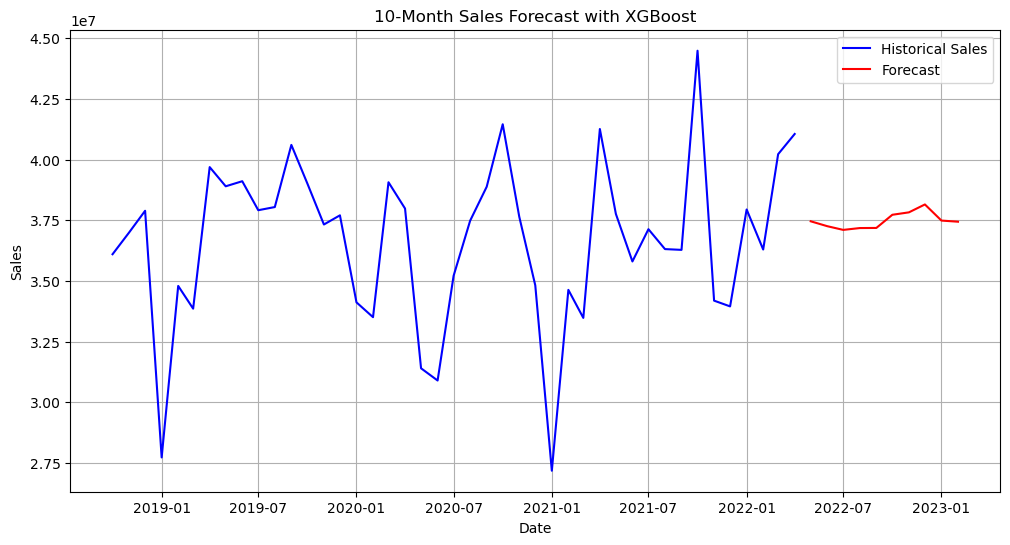

/var/folders/z6/_vn8cndd4x5dmx2cpjfdkjdr0000gn/T/ipykernel_31216/681904062.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set_1["Sales_EUR"] = results["yhat"]


,Mapped_GCK,Sales_EUR
Month Year,,
2022-05-01,#1,37456288.0
2022-06-01,#1,37254620.0
2022-07-01,#1,37101728.0
2022-08-01,#1,37177364.0
2022-09-01,#1,37182120.0
2022-10-01,#1,37724816.0
2022-11-01,#1,37824196.0
2022-12-01,#1,38149756.0
2023-01-01,#1,37485560.0


In [99]:
best_model, best_params, best_rmse, best_model_name = select_best_model(
    prophet_best_model_1, prophet_best_params_1, prophet_best_rmse_1, "Prophet",
    xgboost_best_model_1, xgboost_best_params_1, xgboost_best_rmse_1, "XGBoost"
    , sarima_best_model_1, sarima_best_params_1, sarima_best_rmse_1, "SARIMA"
)
print(f"Best Model: {best_model_name}")
print("Best Parameters:", best_params)
print("Best RMSE:", best_rmse)

if best_model_name == "XGBoost":
    results = xgboost_forecast(
        sales_agg1,
        df_market_1,
        period=10,
        params =best_params,
    )
elif best_model_name == "SARIMA":
    results = sarima_forecast(
        sales_agg1,
        period=10,
        params =best_params,
    )
else:
    results = prophet_forecast(
        sales_agg1,
        df_market_1,
        period=10,
        param =best_params,
    )
results.set_index('ds',inplace = True)
test_set_1.set_index('Month Year', inplace = True)
test_set_1["Sales_EUR"] = results["yhat"]
test_set_1

# Product 3

In [100]:
# selecte only the features that are selected in the feature selection step
test_set_3 = test_set[test_set['Mapped_GCK'] == '#3']
df_market_3 = df_market[selected_features_3]
df_market_3.head()

,MAB_ELE_SHP840_lag_6,WKLWEUR840_org_lag_5,MAB_ELE_PRO826_lag_1,PRO27826_org,PRI27840_org_lag_5,PRO28392_org_lag_6,MAB_ELE_PRO826_lag_5,MAB_ELE_SHP392_lag_5,MAB_ELE_SHP392_lag_1,MAB_ELE_SHP826_lag_3
date,,,,,,,,,,
2004-02-01,NaN,NaN,NaN,120.706516,NaN,NaN,NaN,NaN,NaN,NaN
2004-03-01,NaN,NaN,111.353812,138.309550,NaN,NaN,NaN,NaN,110.495272,NaN
2004-04-01,NaN,NaN,127.558608,115.557330,NaN,NaN,NaN,NaN,144.686166,NaN
2004-05-01,NaN,NaN,108.732297,119.269534,NaN,NaN,NaN,NaN,102.655769,77.766367
2004-06-01,NaN,NaN,110.645200,128.849416,NaN,NaN,NaN,NaN,100.305285,77.829225


## Xgboost

In [101]:
X_train, X_val, y_train, y_val = train_val_split(sales_agg3, df_market_3, train_size = 0.8)

X_val.info() 

xgboost_best_model_3, xgboost_best_params_3, xgboost_best_rmse_3 = model_evaluation_XGboost(X_train,
                                                                                             y_train, 
                                                                                             X_val, y_val, 
                                                                                             xgboost_param_grid)

print("Best Params:", xgboost_best_params_3)
print("Validation RMSE:", xgboost_best_rmse_3)

<class 'pandas.core.frame.DataFrame'>
Index: 9 entries, 2021-08-01 to 2022-04-01
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   MAB_ELE_SHP840_lag_6  9 non-null      float64
 1   WKLWEUR840_org_lag_5  9 non-null      float64
 2   MAB_ELE_PRO826_lag_1  9 non-null      float64
 3   PRO27826_org          9 non-null      float64
 4   PRI27840_org_lag_5    9 non-null      float64
 5   PRO28392_org_lag_6    9 non-null      float64
 6   MAB_ELE_PRO826_lag_5  9 non-null      float64
 7   MAB_ELE_SHP392_lag_5  9 non-null      float64
 8   MAB_ELE_SHP392_lag_1  9 non-null      float64
 9   MAB_ELE_SHP826_lag_3  9 non-null      float64
dtypes: float64(10)
memory usage: 792.0+ bytes
Params: {'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.5, 'colsample_bytree': 0.5, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 0} => RMSE: 3085381.6848, Relative RMSE: 0.2155
Best Params: {'n_estimator

## Prophet

In [102]:
prophet_best_model_3, prophet_best_params_3, prophet_best_rmse_3 = model_evaluation_prophet(X_train,
                                                                                             y_train, 
                                                                                             X_val, 
                                                                                             y_val, 
                                                                                             prophet_param_grid)

print("Best Params:", prophet_best_params_3)

print("Validation RMSE:", prophet_best_rmse_3)

13:28:23 - cmdstanpy - INFO - Chain [1] start processing
13:28:23 - cmdstanpy - INFO - Chain [1] done processing


Params: {'seasonality_mode': 'additive', 'yearly_seasonality': True, 'seasonality_prior_scale': 0.01, 'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8} => RMSE: 2505301.4050, Relative RMSE: 0.1750
Best Params: {'seasonality_mode': 'additive', 'yearly_seasonality': True, 'seasonality_prior_scale': 0.01, 'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8}
Validation RMSE: 2505301.405036073


## Sarima

In [ ]:
sarima_best_model_3, sarima_best_params_3, sarima_best_rmse_3 = model_evaluation_SARIMA(y_train, 
                                                             y_val, 
                                                             sarima_param_grid)

print("Best Params:", sarima_best_params_3)
print("Validation RMSE:", sarima_best_rmse_3)

## Final prediction

13:28:23 - cmdstanpy - INFO - Chain [1] start processing


Best Model: Prophet
Best Parameters: {'seasonality_mode': 'additive', 'yearly_seasonality': True, 'seasonality_prior_scale': 0.01, 'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8}
Best RMSE: 2505301.405036073


13:28:26 - cmdstanpy - INFO - Chain [1] done processing


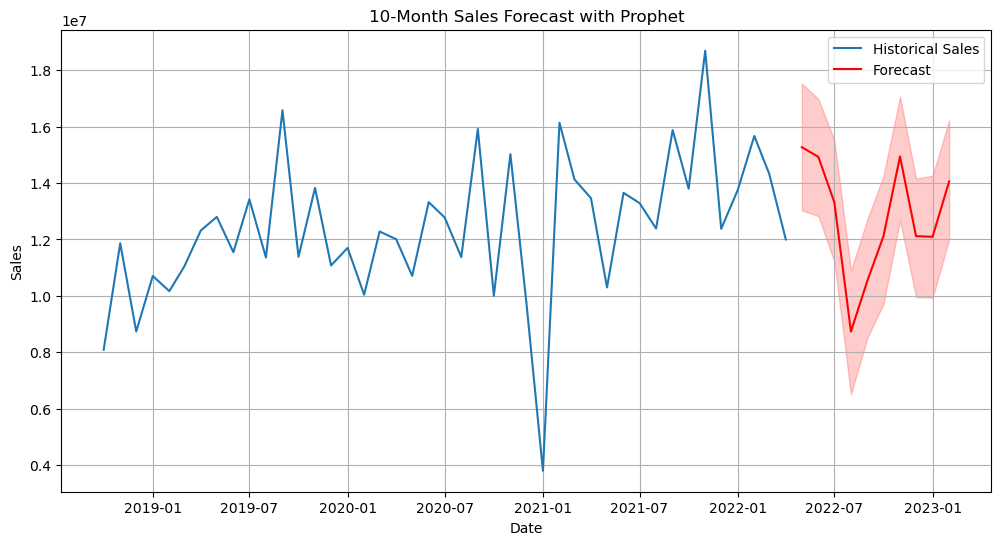

/var/folders/z6/_vn8cndd4x5dmx2cpjfdkjdr0000gn/T/ipykernel_31216/2768713773.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set_3["Sales_EUR"] = results["yhat"]


,Mapped_GCK,Sales_EUR
Month Year,,
2022-05-01,#3,1.526800e+07
2022-06-01,#3,1.492495e+07
2022-07-01,#3,1.331479e+07
2022-08-01,#3,8.733940e+06
2022-09-01,#3,1.054408e+07
2022-10-01,#3,1.211420e+07
2022-11-01,#3,1.494016e+07
2022-12-01,#3,1.211596e+07
2023-01-01,#3,1.209493e+07


In [ ]:
best_model, best_params, best_rmse, best_model_name = select_best_model(
    prophet_best_model_3, prophet_best_params_3, prophet_best_rmse_3, "Prophet",
    xgboost_best_model_3, xgboost_best_params_3, xgboost_best_rmse_3, "XGBoost"
    , sarima_best_model_3, sarima_best_params_3, sarima_best_rmse_3, "SARIMA"
)
print(f"Best Model: {best_model_name}")
print("Best Parameters:", best_params)
print("Best RMSE:", best_rmse)

if best_model_name == "XGBoost":
    results = xgboost_forecast(
        sales_agg3,
        df_market_3,
        period=10,
        params =best_params,
    )
elif best_model_name == "SARIMA":
    results = sarima_forecast(
        sales_agg3,
        period=10,
        params =best_params,
    )
else:
    results = prophet_forecast(
        sales_agg3,
        df_market_3,
        period=10,
        param =best_params,
    )
results.set_index('ds',inplace = True)
test_set_3.set_index('Month Year', inplace = True)
test_set_3["Sales_EUR"] = results["yhat"]
test_set_3

# Product 4

In [104]:
test_set_4 = test_set[test_set['Mapped_GCK'] == '#4']
df_market_4 = df_market[selected_features_4]
df_market_4.head()

,PRO27756_org_lag_5,WKLWEUR840_org_lag_3,PRI27276_org_lag_2,PRO28392_org_lag_4,MAB_ELE_PRO156_lag_4,PRO28756_org_lag_6,PRO28392_org_lag_1,MAB_ELE_SHP392_lag_6
date,,,,,,,,
2004-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-03-01,NaN,NaN,NaN,NaN,NaN,NaN,110.890034,NaN
2004-04-01,NaN,NaN,93.230453,NaN,NaN,NaN,141.176853,NaN
2004-05-01,NaN,1.2646,93.335678,NaN,NaN,NaN,105.648765,NaN
2004-06-01,NaN,1.2262,93.440903,110.890034,16.940704,NaN,101.990361,NaN


## Xgboost

In [105]:
X_train, X_val, y_train, y_val = train_val_split(sales_agg4, df_market_4, train_size = 0.8)

X_val.info() 

xgboost_best_model_4, xgboost_best_params_4, xgboost_best_rmse_4 = model_evaluation_XGboost(X_train,
                                                                                             y_train, 
                                                                                             X_val, y_val, 
                                                                                             xgboost_param_grid)

print("Best Params:", xgboost_best_params_4)
print("Validation RMSE:", xgboost_best_rmse_4)

<class 'pandas.core.frame.DataFrame'>
Index: 9 entries, 2021-08-01 to 2022-04-01
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   PRO27756_org_lag_5    9 non-null      float64
 1   WKLWEUR840_org_lag_3  9 non-null      float64
 2   PRI27276_org_lag_2    9 non-null      float64
 3   PRO28392_org_lag_4    9 non-null      float64
 4   MAB_ELE_PRO156_lag_4  9 non-null      float64
 5   PRO28756_org_lag_6    9 non-null      float64
 6   PRO28392_org_lag_1    9 non-null      float64
 7   MAB_ELE_SHP392_lag_6  9 non-null      float64
dtypes: float64(8)
memory usage: 648.0+ bytes
Params: {'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.5, 'colsample_bytree': 0.5, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 0} => RMSE: 117764.8240, Relative RMSE: 0.3998
Best Params: {'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.5, 'colsample_bytree': 0.5, 'gamma': 0, 're

## Prophet

In [106]:
prophet_best_model_4, prophet_best_params_4, prophet_best_rmse_4 = model_evaluation_prophet(X_train,
                                                                                             y_train, 
                                                                                             X_val, 
                                                                                             y_val, 
                                                                                             prophet_param_grid)

print("Best Params:", prophet_best_params_4)

print("Validation RMSE:", prophet_best_rmse_4)

13:28:27 - cmdstanpy - INFO - Chain [1] start processing
13:28:27 - cmdstanpy - INFO - Chain [1] done processing


Params: {'seasonality_mode': 'additive', 'yearly_seasonality': True, 'seasonality_prior_scale': 0.01, 'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8} => RMSE: 136482.4471, Relative RMSE: 0.4634
Best Params: {'seasonality_mode': 'additive', 'yearly_seasonality': True, 'seasonality_prior_scale': 0.01, 'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8}
Validation RMSE: 136482.4470850788


## Sarima

In [ ]:
sarima_best_model_4, sarima_best_params_4, sarima_best_rmse_4 = model_evaluation_SARIMA(y_train, 
                                                             y_val, 
                                                             sarima_param_grid)

print("Best Params:", sarima_best_params_4)
print("Validation RMSE:", sarima_best_rmse_4)

## Final prediction

Best Model: XGBoost
Best Parameters: {'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.5, 'colsample_bytree': 0.5, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 0}
Best RMSE: 117764.82397184748


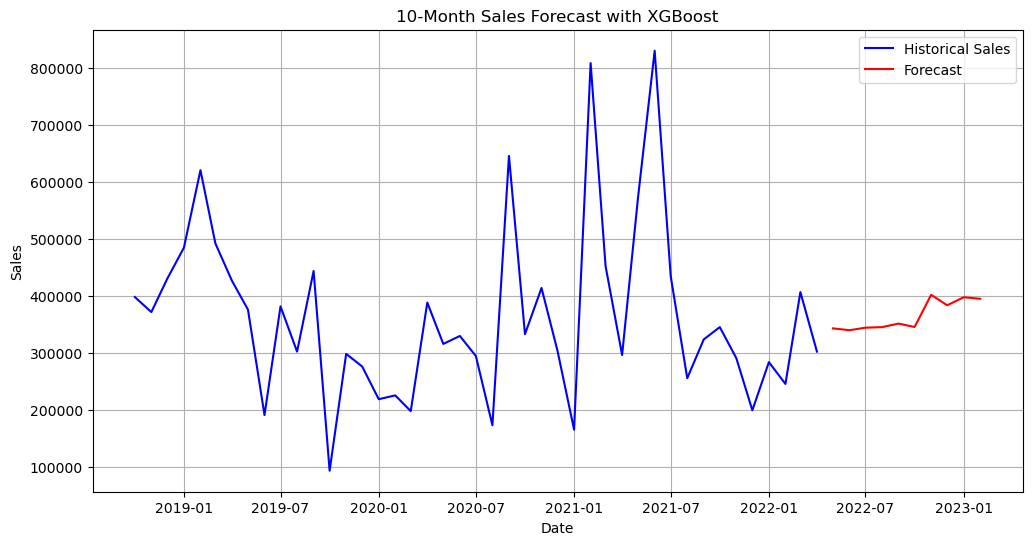

/var/folders/z6/_vn8cndd4x5dmx2cpjfdkjdr0000gn/T/ipykernel_31216/679592135.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set_4["Sales_EUR"] = results["yhat"]


,Mapped_GCK,Sales_EUR
Month Year,,
2022-05-01,#4,342756.12500
2022-06-01,#4,339548.96875
2022-07-01,#4,343972.50000
2022-08-01,#4,344960.31250
2022-09-01,#4,351140.12500
2022-10-01,#4,345168.12500
2022-11-01,#4,401593.15625
2022-12-01,#4,383251.40625
2023-01-01,#4,397273.71875


In [ ]:
best_model, best_params, best_rmse, best_model_name = select_best_model(
    prophet_best_model_4, prophet_best_params_4, prophet_best_rmse_4, "Prophet",
    xgboost_best_model_4, xgboost_best_params_4, xgboost_best_rmse_4, "XGBoost"
    , sarima_best_model_4, sarima_best_params_4, sarima_best_rmse_4, "SARIMA"
)
print(f"Best Model: {best_model_name}")
print("Best Parameters:", best_params)
print("Best RMSE:", best_rmse)

if best_model_name == "XGBoost":
    results = xgboost_forecast(
        sales_agg4,
        df_market_4,
        period=10,
        params =best_params,
    )
elif best_model_name == "SARIMA":
    results = sarima_forecast(
        sales_agg4,
        period=10,
        params =best_params,
    )
else:
    results = prophet_forecast(
        sales_agg4,
        df_market_4,
        period=10,
        param =best_params,
    )
results.set_index('ds',inplace = True)
test_set_4.set_index('Month Year', inplace = True)
test_set_4["Sales_EUR"] = results["yhat"]
test_set_4

# Product 5

In [108]:
# selecte only the features that are selected in the feature selection step
test_set_5 = test_set[test_set['Mapped_GCK'] == '#5']
df_market_5 = df_market[selected_features_5]
df_market_5.head()

,MAB_ELE_SHP250_lag_1,PRO28392_org_lag_3,MAB_ELE_SHP392,MAB_ELE_PRO826_lag_5,PRO271000_org_lag_5,PRO27392_org,PRI27840_org
date,,,,,,,
2004-02-01,NaN,NaN,110.495272,NaN,NaN,106.161262,78.969864
2004-03-01,83.458866,NaN,144.686166,NaN,NaN,140.288741,79.673569
2004-04-01,106.168192,NaN,102.655769,NaN,NaN,106.271197,80.337639
2004-05-01,92.007646,110.890034,100.305285,NaN,NaN,101.608710,80.798828
2004-06-01,85.696486,141.176853,119.616380,NaN,NaN,116.655248,80.913490


## Xgboost

In [109]:
X_train, X_val, y_train, y_val = train_val_split(sales_agg5, df_market_5, train_size = 0.8)

X_val.info() 

xgboost_best_model_5, xgboost_best_params_5, xgboost_best_rmse_5 = model_evaluation_XGboost(X_train,
                                                                                             y_train, 
                                                                                             X_val, y_val, 
                                                                                             xgboost_param_grid)

print("Best Params:", xgboost_best_params_5)
print("Validation RMSE:", xgboost_best_rmse_5)

<class 'pandas.core.frame.DataFrame'>
Index: 9 entries, 2021-08-01 to 2022-04-01
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   MAB_ELE_SHP250_lag_1  9 non-null      float64
 1   PRO28392_org_lag_3    9 non-null      float64
 2   MAB_ELE_SHP392        9 non-null      float64
 3   MAB_ELE_PRO826_lag_5  9 non-null      float64
 4   PRO271000_org_lag_5   9 non-null      float64
 5   PRO27392_org          9 non-null      float64
 6   PRI27840_org          9 non-null      float64
dtypes: float64(7)
memory usage: 576.0+ bytes
Params: {'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.5, 'colsample_bytree': 0.5, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 0} => RMSE: 4136164.9505, Relative RMSE: 0.3582
Best Params: {'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.5, 'colsample_bytree': 0.5, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 0}
Validation RMSE: 413

## Prophet

In [110]:
prophet_best_model_5, prophet_best_params_5, prophet_best_rmse_5 = model_evaluation_prophet(X_train,
                                                                                             y_train, 
                                                                                             X_val, 
                                                                                             y_val, 
                                                                                             prophet_param_grid)

print("Best Params:", prophet_best_params_5)

print("Validation RMSE:", prophet_best_rmse_5)

13:28:27 - cmdstanpy - INFO - Chain [1] start processing
13:28:28 - cmdstanpy - INFO - Chain [1] done processing


Params: {'seasonality_mode': 'additive', 'yearly_seasonality': True, 'seasonality_prior_scale': 0.01, 'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8} => RMSE: 4209233.8790, Relative RMSE: 0.3645
Best Params: {'seasonality_mode': 'additive', 'yearly_seasonality': True, 'seasonality_prior_scale': 0.01, 'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8}
Validation RMSE: 4209233.878992504


## Sarima

In [ ]:
sarima_best_model_5, sarima_best_params_5, sarima_best_rmse_5 = model_evaluation_SARIMA(y_train, 
                                                             y_val, 
                                                             sarima_param_grid)

print("Best Params:", sarima_best_params_5)
print("Validation RMSE:", sarima_best_rmse_5)

## Final prediction

Best Model: XGBoost
Best Parameters: {'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.5, 'colsample_bytree': 0.5, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 0}
Best RMSE: 4136164.9504908584


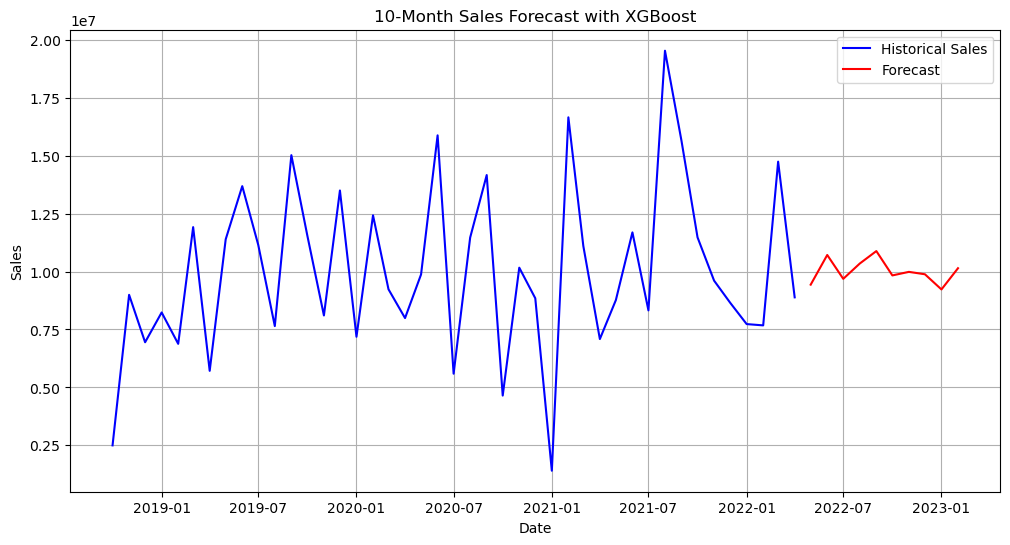

/var/folders/z6/_vn8cndd4x5dmx2cpjfdkjdr0000gn/T/ipykernel_31216/3577769835.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set_5["Sales_EUR"] = results["yhat"]


,Mapped_GCK,Sales_EUR
Month Year,,
2022-05-01,#5,9432225.0
2022-06-01,#5,10712423.0
2022-07-01,#5,9683879.0
2022-08-01,#5,10344451.0
2022-09-01,#5,10880856.0
2022-10-01,#5,9830917.0
2022-11-01,#5,9984075.0
2022-12-01,#5,9880619.0
2023-01-01,#5,9225877.0


In [ ]:
best_model, best_params, best_rmse, best_model_name = select_best_model(
    prophet_best_model_5, prophet_best_params_5, prophet_best_rmse_5, "Prophet",
    xgboost_best_model_5, xgboost_best_params_5, xgboost_best_rmse_5, "XGBoost"
    , sarima_best_model_5, sarima_best_params_5, sarima_best_rmse_5, "SARIMA"
)
print(f"Best Model: {best_model_name}")
print("Best Parameters:", best_params)
print("Best RMSE:", best_rmse)

if best_model_name == "XGBoost":
    results = xgboost_forecast(
        sales_agg5,
        df_market_5,
        period=10,
        params =best_params,
    )
elif best_model_name == "SARIMA":
    results = sarima_forecast(
        sales_agg5,
        period=10,
        params =best_params,
    )
else:
    results = prophet_forecast(
        sales_agg5,
        df_market_5,
        period=10,
        param =best_params,
    )
results.set_index('ds',inplace = True)
test_set_5.set_index('Month Year', inplace = True)
test_set_5["Sales_EUR"] = results["yhat"]
test_set_5

# Product 6

In [112]:
# selecte only the features that are selected in the feature selection step
test_set_6 = test_set[test_set['Mapped_GCK'] == '#6']
df_market_6 = df_market[selected_features_6]
df_market_6.head()

,PRO27276_org,MAB_ELE_PRO392_lag_5,PRO27276_org_lag_1,MAB_ELE_SHP250_lag_1,WKLWEUR840_org_lag_2,PRO28756_org,PRI27250_org_lag_3,MAB_ELE_SHP156_lag_4
date,,,,,,,,
2004-02-01,85.913200,NaN,NaN,NaN,NaN,96.177481,NaN,NaN
2004-03-01,97.670815,NaN,85.913200,83.458866,NaN,96.250927,NaN,NaN
2004-04-01,87.253983,NaN,97.670815,106.168192,1.2646,96.330211,NaN,NaN
2004-05-01,84.675552,NaN,87.253983,92.007646,1.2262,96.413549,96.864647,NaN
2004-06-01,95.401802,NaN,84.675552,85.696486,1.1985,96.499291,96.864653,16.940704


## Xgboost

In [113]:
X_train, X_val, y_train, y_val = train_val_split(sales_agg6, df_market_6, train_size = 0.8)

X_val.info() 

xgboost_best_model_6, xgboost_best_params_6, xgboost_best_rmse_6 = model_evaluation_XGboost(X_train,
                                                                                             y_train, 
                                                                                             X_val, y_val, 
                                                                                             xgboost_param_grid)

print("Best Params:", xgboost_best_params_6)
print("Validation RMSE:", xgboost_best_rmse_6)


<class 'pandas.core.frame.DataFrame'>
Index: 9 entries, 2021-08-01 to 2022-04-01
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   PRO27276_org          9 non-null      float64
 1   MAB_ELE_PRO392_lag_5  9 non-null      float64
 2   PRO27276_org_lag_1    9 non-null      float64
 3   MAB_ELE_SHP250_lag_1  9 non-null      float64
 4   WKLWEUR840_org_lag_2  9 non-null      float64
 5   PRO28756_org          9 non-null      float64
 6   PRI27250_org_lag_3    9 non-null      float64
 7   MAB_ELE_SHP156_lag_4  9 non-null      float64
dtypes: float64(8)
memory usage: 648.0+ bytes
Params: {'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.5, 'colsample_bytree': 0.5, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 0} => RMSE: 255362.5382, Relative RMSE: 0.6663
Best Params: {'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.5, 'colsample_bytree': 0.5, 'gamma': 0, 're

## Prophet

In [114]:
prophet_best_model_6, prophet_best_params_6, prophet_best_rmse_6 = model_evaluation_prophet(X_train,
                                                                                             y_train, 
                                                                                             X_val, 
                                                                                             y_val, 
                                                                                             prophet_param_grid)

print("Best Params:", prophet_best_params_6)

print("Validation RMSE:", prophet_best_rmse_6)

13:28:28 - cmdstanpy - INFO - Chain [1] start processing
13:28:28 - cmdstanpy - INFO - Chain [1] done processing


Params: {'seasonality_mode': 'additive', 'yearly_seasonality': True, 'seasonality_prior_scale': 0.01, 'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8} => RMSE: 248320.9212, Relative RMSE: 0.6479
Best Params: {'seasonality_mode': 'additive', 'yearly_seasonality': True, 'seasonality_prior_scale': 0.01, 'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8}
Validation RMSE: 248320.92117510058


## Sarima

In [ ]:
sarima_best_model_6, sarima_best_params_6, sarima_best_rmse_6 = model_evaluation_SARIMA(y_train, 
                                                             y_val, 
                                                             sarima_param_grid)

print("Best Params:", sarima_best_params_6)
print("Validation RMSE:", sarima_best_rmse_6)

## Final prediction

13:28:28 - cmdstanpy - INFO - Chain [1] start processing
13:28:28 - cmdstanpy - INFO - Chain [1] done processing


Best Model: Prophet
Best Parameters: {'seasonality_mode': 'additive', 'yearly_seasonality': True, 'seasonality_prior_scale': 0.01, 'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8}
Best RMSE: 248320.92117510058


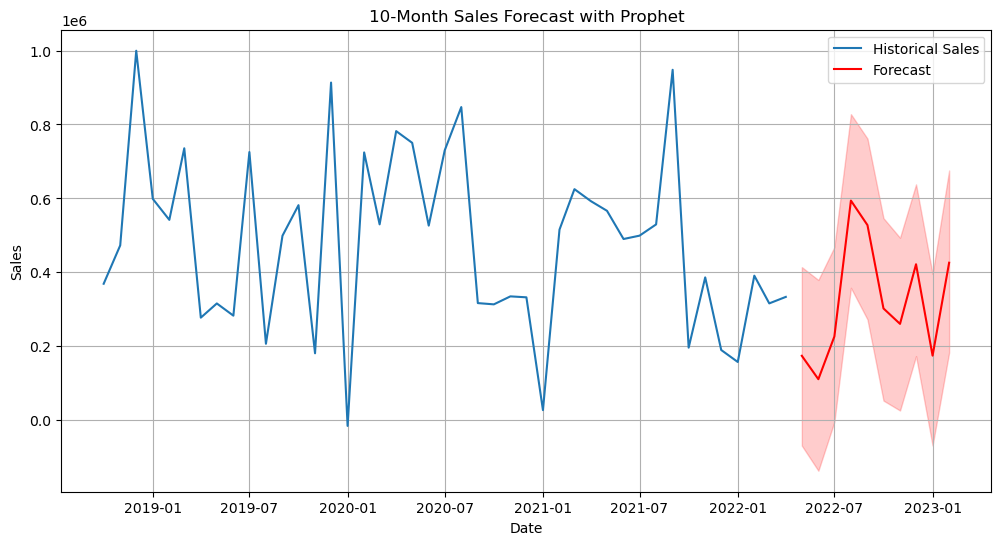

/var/folders/z6/_vn8cndd4x5dmx2cpjfdkjdr0000gn/T/ipykernel_31216/2742990063.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set_6["Sales_EUR"] = results["yhat"]


,Mapped_GCK,Sales_EUR
Month Year,,
2022-05-01,#6,174422.175703
2022-06-01,#6,111117.583348
2022-07-01,#6,226608.836321
2022-08-01,#6,594175.094433
2022-09-01,#6,527806.443833
2022-10-01,#6,302448.670774
2022-11-01,#6,260736.181056
2022-12-01,#6,422010.537946
2023-01-01,#6,174780.476195


In [ ]:
best_model, best_params, best_rmse, best_model_name = select_best_model(
    prophet_best_model_6, prophet_best_params_6, prophet_best_rmse_6, "Prophet",
    xgboost_best_model_6, xgboost_best_params_6, xgboost_best_rmse_6, "XGBoost"
    , sarima_best_model_6, sarima_best_params_6, sarima_best_rmse_6, "SARIMA"
)
print(f"Best Model: {best_model_name}")
print("Best Parameters:", best_params)
print("Best RMSE:", best_rmse)

if best_model_name == "XGBoost":
    results = xgboost_forecast(
        sales_agg6,
        df_market_6,
        period=10,
        params =best_params,
    )
elif best_model_name == "SARIMA":
    results = sarima_forecast(
        sales_agg6,
        period=10,
        params =best_params,
    )
else:
    results = prophet_forecast(
        sales_agg6,
        df_market_6,
        period=10,
        param =best_params,
    )
results.set_index('ds',inplace = True)
test_set_6.set_index('Month Year', inplace = True)
test_set_6["Sales_EUR"] = results["yhat"]
test_set_6

# Product 8

In [116]:
# selecte only the features that are selected in the feature selection step
test_set_8 = test_set[test_set['Mapped_GCK'] == '#8']
df_market_8 = df_market[selected_features_8]
df_market_8.head()

,MAB_ELE_SHP840_lag_6,PRO28392_org_lag_4,MAB_ELE_SHP250_lag_3,MAB_ELE_SHP250_lag_4,WKLWEUR840_org_lag_1,MAB_ELE_SHP392_lag_1,PRO27826_org_lag_3,PRO27392_org_lag_4
date,,,,,,,,
2004-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-03-01,NaN,NaN,NaN,NaN,1.2646,110.495272,NaN,NaN
2004-04-01,NaN,NaN,NaN,NaN,1.2262,144.686166,NaN,NaN
2004-05-01,NaN,NaN,83.458866,NaN,1.1985,102.655769,120.706516,NaN
2004-06-01,NaN,110.890034,106.168192,83.458866,1.2007,100.305285,138.309550,106.161262


## Xgboost

In [117]:
X_train, X_val, y_train, y_val = train_val_split(sales_agg8, df_market_8, train_size = 0.8)

X_val.info() 

xgboost_best_model_8, xgboost_best_params_8, xgboost_best_rmse_8 = model_evaluation_XGboost(X_train,
                                                                                             y_train, 
                                                                                             X_val, y_val, 
                                                                                             xgboost_param_grid)

print("Best Params:", xgboost_best_params_8)
print("Validation RMSE:", xgboost_best_rmse_8)

<class 'pandas.core.frame.DataFrame'>
Index: 9 entries, 2021-08-01 to 2022-04-01
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   MAB_ELE_SHP840_lag_6  9 non-null      float64
 1   PRO28392_org_lag_4    9 non-null      float64
 2   MAB_ELE_SHP250_lag_3  9 non-null      float64
 3   MAB_ELE_SHP250_lag_4  9 non-null      float64
 4   WKLWEUR840_org_lag_1  9 non-null      float64
 5   MAB_ELE_SHP392_lag_1  9 non-null      float64
 6   PRO27826_org_lag_3    9 non-null      float64
 7   PRO27392_org_lag_4    9 non-null      float64
dtypes: float64(8)
memory usage: 648.0+ bytes
Params: {'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.5, 'colsample_bytree': 0.5, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 0} => RMSE: 731098.1868, Relative RMSE: 0.5743
Best Params: {'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.5, 'colsample_bytree': 0.5, 'gamma': 0, 're

## Prophet

In [118]:
prophet_best_model_8, prophet_best_params_8, prophet_best_rmse_8 = model_evaluation_prophet(X_train,
                                                                                             y_train, 
                                                                                             X_val, 
                                                                                             y_val, 
                                                                                             prophet_param_grid)

print("Best Params:", prophet_best_params_8)

print("Validation RMSE:", prophet_best_rmse_8)

13:28:28 - cmdstanpy - INFO - Chain [1] start processing
13:28:28 - cmdstanpy - INFO - Chain [1] done processing


Params: {'seasonality_mode': 'additive', 'yearly_seasonality': True, 'seasonality_prior_scale': 0.01, 'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8} => RMSE: 517706.6094, Relative RMSE: 0.4066
Best Params: {'seasonality_mode': 'additive', 'yearly_seasonality': True, 'seasonality_prior_scale': 0.01, 'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8}
Validation RMSE: 517706.6094401052


## Sarima

In [ ]:
sarima_best_model_8, sarima_best_params_8, sarima_best_rmse_8 = model_evaluation_SARIMA(y_train, 
                                                             y_val, 
                                                             sarima_param_grid)

print("Best Params:", sarima_best_params_8)
print("Validation RMSE:", sarima_best_rmse_8)

## Final prediction

13:28:29 - cmdstanpy - INFO - Chain [1] start processing


Best Model: Prophet
Best Parameters: {'seasonality_mode': 'additive', 'yearly_seasonality': True, 'seasonality_prior_scale': 0.01, 'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8}
Best RMSE: 517706.6094401052


13:28:29 - cmdstanpy - INFO - Chain [1] done processing


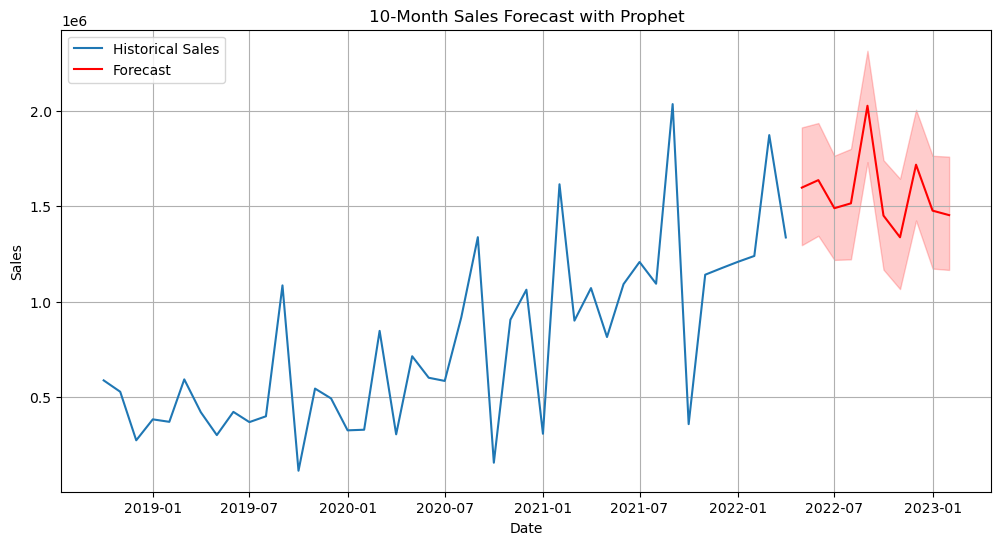

/var/folders/z6/_vn8cndd4x5dmx2cpjfdkjdr0000gn/T/ipykernel_31216/2832595504.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set_8["Sales_EUR"] = results["yhat"]


,Mapped_GCK,Sales_EUR
Month Year,,
2022-05-01,#8,1.597902e+06
2022-06-01,#8,1.637225e+06
2022-07-01,#8,1.489900e+06
2022-08-01,#8,1.515365e+06
2022-09-01,#8,2.027548e+06
2022-10-01,#8,1.451100e+06
2022-11-01,#8,1.337160e+06
2022-12-01,#8,1.718256e+06
2023-01-01,#8,1.476980e+06


In [ ]:
best_model, best_params, best_rmse, best_model_name = select_best_model(
    prophet_best_model_8, prophet_best_params_8, prophet_best_rmse_8, "Prophet",
    xgboost_best_model_8, xgboost_best_params_8, xgboost_best_rmse_8, "XGBoost"
    , sarima_best_model_8, sarima_best_params_8, sarima_best_rmse_8, "SARIMA"
)
print(f"Best Model: {best_model_name}")
print("Best Parameters:", best_params)
print("Best RMSE:", best_rmse)

if best_model_name == "XGBoost":
    results = xgboost_forecast(
        sales_agg8,
        df_market_8,
        period=10,
        params =best_params,
    )
elif best_model_name == "SARIMA":
    results = sarima_forecast(
        sales_agg8,
        period=10,
        params =best_params,
    )
else:
    results = prophet_forecast(
        sales_agg8,
        df_market_8,
        period=10,
        param =best_params,
    )
results.set_index('ds',inplace = True)
test_set_8.set_index('Month Year', inplace = True)
test_set_8["Sales_EUR"] = results["yhat"]
test_set_8

# Product 9

In [120]:
# selecte only the features that are selected in the feature selection step
test_set_9 = test_set[test_set['Mapped_GCK'] == '#9']
df_market_9 = df_market[selected_features_9]
df_market_9.head()

,RohCOPPER1000_org_lag_6,WKLWEUR840_org_lag_3,MAB_ELE_SHP250_lag_3,MAB_ELE_SHP840_lag_5,WKLWEUR840_org_lag_4,PRO27826_org_lag_1
date,,,,,,
2004-02-01,NaN,NaN,NaN,NaN,NaN,NaN
2004-03-01,NaN,NaN,NaN,NaN,NaN,120.706516
2004-04-01,NaN,NaN,NaN,NaN,NaN,138.309550
2004-05-01,NaN,1.2646,83.458866,NaN,NaN,115.557330
2004-06-01,NaN,1.2262,106.168192,NaN,1.2646,119.269534


## Xgboost 

In [121]:
X_train, X_val, y_train, y_val = train_val_split(sales_agg9, df_market_9, train_size = 0.8)

X_val.info() 

xgboost_best_model_9, xgboost_best_params_9, xgboost_best_rmse_9 = model_evaluation_XGboost(X_train,
                                                                                             y_train, 
                                                                                             X_val, y_val, 
                                                                                             xgboost_param_grid)

print("Best Params:", xgboost_best_params_9)
print("Validation RMSE:", xgboost_best_rmse_9)

<class 'pandas.core.frame.DataFrame'>
Index: 9 entries, 2021-08-01 to 2022-04-01
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   RohCOPPER1000_org_lag_6  9 non-null      float64
 1   WKLWEUR840_org_lag_3     9 non-null      float64
 2   MAB_ELE_SHP250_lag_3     9 non-null      float64
 3   MAB_ELE_SHP840_lag_5     9 non-null      float64
 4   WKLWEUR840_org_lag_4     9 non-null      float64
 5   PRO27826_org_lag_1       9 non-null      float64
dtypes: float64(6)
memory usage: 504.0+ bytes
Params: {'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.5, 'colsample_bytree': 0.5, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 0} => RMSE: 6317.0011, Relative RMSE: 1.1302
Best Params: {'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.5, 'colsample_bytree': 0.5, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 0}
Validation RMSE: 6317.0011347258005


## Prophet

In [122]:
prophet_best_model_9, prophet_best_params_9, prophet_best_rmse_9 = model_evaluation_prophet(X_train,
                                                                                             y_train, 
                                                                                             X_val, 
                                                                                             y_val, 
                                                                                             prophet_param_grid)

print("Best Params:", prophet_best_params_9)

print("Validation RMSE:", prophet_best_rmse_9)

13:28:29 - cmdstanpy - INFO - Chain [1] start processing
13:28:29 - cmdstanpy - INFO - Chain [1] done processing


Params: {'seasonality_mode': 'additive', 'yearly_seasonality': True, 'seasonality_prior_scale': 0.01, 'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8} => RMSE: 9484.0695, Relative RMSE: 1.6969
Best Params: {'seasonality_mode': 'additive', 'yearly_seasonality': True, 'seasonality_prior_scale': 0.01, 'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8}
Validation RMSE: 9484.06952864872


## Sarima

In [ ]:
sarima_best_model_9, sarima_best_params_9, sarima_best_rmse_9 = model_evaluation_SARIMA(y_train, 
                                                             y_val, 
                                                             sarima_param_grid)

print("Best Params:", sarima_best_params_9)
print("Validation RMSE:", sarima_best_rmse_9)

## Final prediction 

Best Model: XGBoost
Best Parameters: {'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.5, 'colsample_bytree': 0.5, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 0}
Best RMSE: 6317.0011347258005


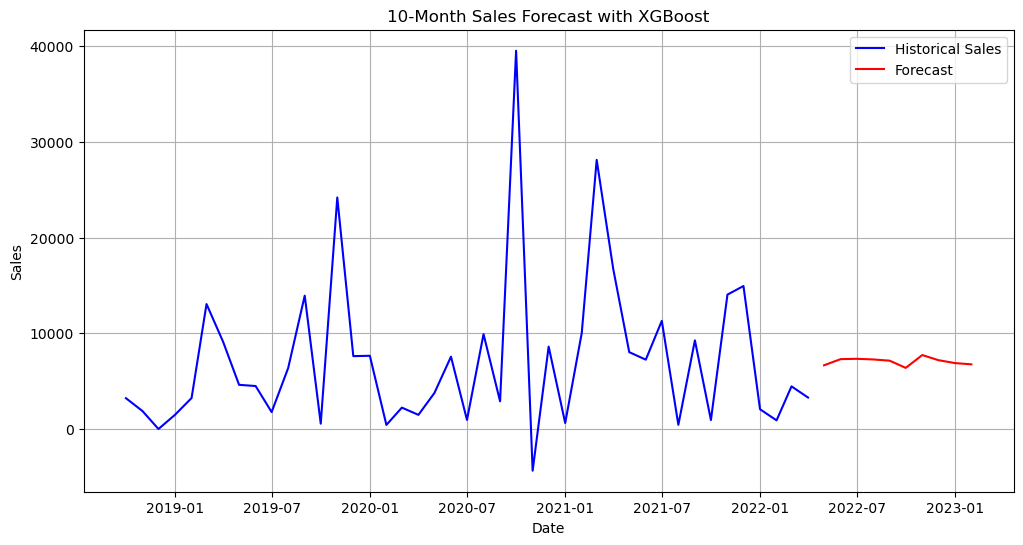

/var/folders/z6/_vn8cndd4x5dmx2cpjfdkjdr0000gn/T/ipykernel_31216/150625292.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set_9["Sales_EUR"] = results["yhat"]


,Mapped_GCK,Sales_EUR
Month Year,,
2022-05-01,#9,6653.916504
2022-06-01,#9,7297.279785
2022-07-01,#9,7331.553223
2022-08-01,#9,7264.445312
2022-09-01,#9,7135.302734
2022-10-01,#9,6383.254395
2022-11-01,#9,7723.500488
2022-12-01,#9,7192.888672
2023-01-01,#9,6886.166992


In [ ]:
best_model, best_params, best_rmse, best_model_name = select_best_model(
    prophet_best_model_9, prophet_best_params_9, prophet_best_rmse_9, "Prophet",
    xgboost_best_model_9, xgboost_best_params_9, xgboost_best_rmse_9, "XGBoost"
    , sarima_best_model_9, sarima_best_params_9, sarima_best_rmse_9, "SARIMA"
)
print(f"Best Model: {best_model_name}")
print("Best Parameters:", best_params)
print("Best RMSE:", best_rmse)

if best_model_name == "XGBoost":
    results = xgboost_forecast(
        sales_agg9,
        df_market_9,
        period=10,
        params =best_params,
    )
elif best_model_name == "SARIMA":
    results = sarima_forecast(
        sales_agg9,
        period=10,
        params =best_params,
    )
else:
    results = prophet_forecast(
        sales_agg9,
        df_market_9,
        period=10,
        param =best_params,
    )
results.set_index('ds',inplace = True)
test_set_9.set_index('Month Year', inplace = True)
test_set_9["Sales_EUR"] = results["yhat"]
test_set_9

# Product 11

In [124]:
# selecte only the features that are selected in the feature selection step
test_set_11 = test_set[test_set['Mapped_GCK'] == '#11']
df_market_11 = df_market[selected_features_11]
df_market_11.head()

,MAB_ELE_SHP392_lag_6,MAB_ELE_SHP250_lag_5,MAB_ELE_PRO826_lag_2,MAB_ELE_SHP392_lag_5,PRO27276_org_lag_5,MAB_ELE_SHP756_lag_5,PRO27826_org_lag_1
date,,,,,,,
2004-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-03-01,NaN,NaN,NaN,NaN,NaN,NaN,120.706516
2004-04-01,NaN,NaN,111.353812,NaN,NaN,NaN,138.309550
2004-05-01,NaN,NaN,127.558608,NaN,NaN,NaN,115.557330
2004-06-01,NaN,NaN,108.732297,NaN,NaN,NaN,119.269534


## Xgboost

In [125]:
X_train, X_val, y_train, y_val = train_val_split(sales_agg11, df_market_11, train_size = 0.8)

X_val.info() 

xgboost_best_model_11, xgboost_best_params_11, xgboost_best_rmse_11 = model_evaluation_XGboost(X_train,
                                                                                             y_train, 
                                                                                             X_val, y_val, 
                                                                                             xgboost_param_grid)

print("Best Params:", xgboost_best_params_11)
print("Validation RMSE:", xgboost_best_rmse_11)

<class 'pandas.core.frame.DataFrame'>
Index: 9 entries, 2021-08-01 to 2022-04-01
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   MAB_ELE_SHP392_lag_6  9 non-null      float64
 1   MAB_ELE_SHP250_lag_5  9 non-null      float64
 2   MAB_ELE_PRO826_lag_2  9 non-null      float64
 3   MAB_ELE_SHP392_lag_5  9 non-null      float64
 4   PRO27276_org_lag_5    9 non-null      float64
 5   MAB_ELE_SHP756_lag_5  9 non-null      float64
 6   PRO27826_org_lag_1    9 non-null      float64
dtypes: float64(7)
memory usage: 576.0+ bytes
Params: {'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.5, 'colsample_bytree': 0.5, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 0} => RMSE: 1044376.6608, Relative RMSE: 0.5664
Best Params: {'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.5, 'colsample_bytree': 0.5, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 0}
Validation RMSE: 104

## Prophet

In [126]:
prophet_best_model_11, prophet_best_params_11, prophet_best_rmse_11 = model_evaluation_prophet(X_train,
                                                                                             y_train, 
                                                                                             X_val, 
                                                                                             y_val, 
                                                                                             prophet_param_grid)

print("Best Params:", prophet_best_params_11)

print("Validation RMSE:", prophet_best_rmse_11)

13:28:29 - cmdstanpy - INFO - Chain [1] start processing
13:28:29 - cmdstanpy - INFO - Chain [1] done processing


Params: {'seasonality_mode': 'additive', 'yearly_seasonality': True, 'seasonality_prior_scale': 0.01, 'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8} => RMSE: 1089065.3890, Relative RMSE: 0.5907
Best Params: {'seasonality_mode': 'additive', 'yearly_seasonality': True, 'seasonality_prior_scale': 0.01, 'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8}
Validation RMSE: 1089065.3890389958


## Sarima

In [ ]:
sarima_best_model_11, sarima_best_params_11, sarima_best_rmse_11 = model_evaluation_SARIMA(y_train, 
                                                             y_val, 
                                                             sarima_param_grid)

print("Best Params:", sarima_best_params_11)
print("Validation RMSE:", sarima_best_rmse_11)

## Final prediction 

Best Model: XGBoost
Best Parameters: {'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.5, 'colsample_bytree': 0.5, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 0}
Best RMSE: 1044376.6608442554


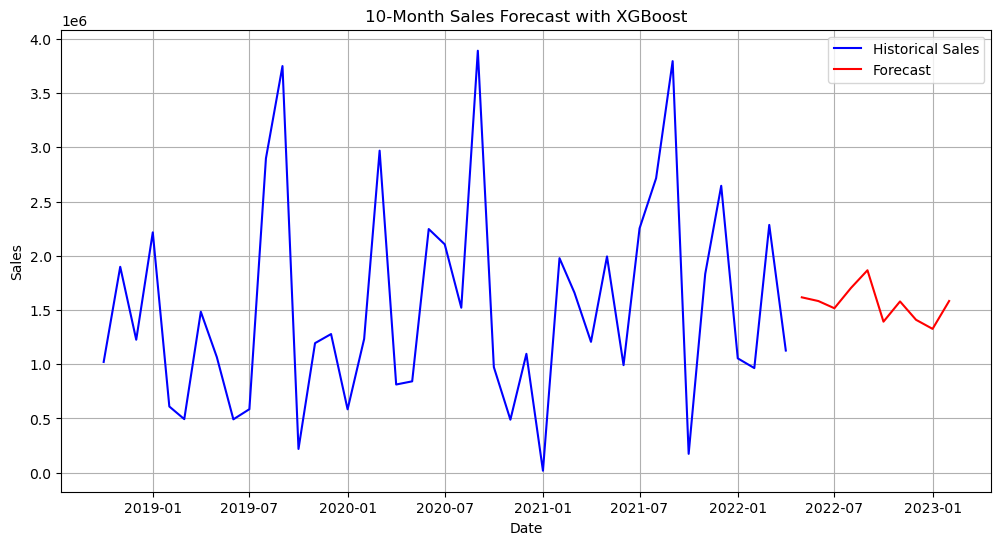

/var/folders/z6/_vn8cndd4x5dmx2cpjfdkjdr0000gn/T/ipykernel_31216/649047386.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set_11["Sales_EUR"] = results["yhat"]


,Mapped_GCK,Sales_EUR
Month Year,,
2022-05-01,#11,1617174.750
2022-06-01,#11,1583026.250
2022-07-01,#11,1516678.875
2022-08-01,#11,1703110.625
2022-09-01,#11,1866835.625
2022-10-01,#11,1392747.500
2022-11-01,#11,1579271.250
2022-12-01,#11,1409941.125
2023-01-01,#11,1326387.500


In [ ]:
best_model, best_params, best_rmse, best_model_name = select_best_model(
    prophet_best_model_11, prophet_best_params_11, prophet_best_rmse_11, "Prophet",
    xgboost_best_model_11, xgboost_best_params_11, xgboost_best_rmse_11, "XGBoost"
    , sarima_best_model_11, sarima_best_params_11, sarima_best_rmse_11, "SARIMA"
)
print(f"Best Model: {best_model_name}")
print("Best Parameters:", best_params)
print("Best RMSE:", best_rmse)

if best_model_name == "XGBoost":
    results = xgboost_forecast(
        sales_agg11,
        df_market_11,
        period=10,
        params =best_params,
    )
elif best_model_name == "SARIMA":
    results = sarima_forecast(
        sales_agg11,
        period=10,
        params =best_params,
    )
else:
    results = prophet_forecast(
        sales_agg11,
        df_market_11,
        period=10,
        param =best_params,
    )
results.set_index('ds',inplace = True)
test_set_11.set_index('Month Year', inplace = True)
test_set_11["Sales_EUR"] = results["yhat"]
test_set_11

# Product 12

In [128]:
# selecte only the features that are selected in the feature selection step
test_set_12 = test_set[test_set['Mapped_GCK'] == '#12']
df_market_12 = df_market[selected_features_12]
df_market_12.head()

,PRO27756_org_lag_3,MAB_ELE_PRO826,WKLWEUR840_org_lag_5,MAB_ELE_PRO826_lag_3,MAB_ELE_PRO156_lag_5,PRO27392_org_lag_2,MAB_ELE_SHP392_lag_5
date,,,,,,,
2004-02-01,NaN,111.353812,NaN,NaN,NaN,NaN,NaN
2004-03-01,NaN,127.558608,NaN,NaN,NaN,NaN,NaN
2004-04-01,NaN,108.732297,NaN,NaN,NaN,106.161262,NaN
2004-05-01,68.677657,110.645200,NaN,111.353812,NaN,140.288741,NaN
2004-06-01,68.452548,122.020960,NaN,127.558608,NaN,106.271197,NaN


## Xgboost

In [129]:
X_train, X_val, y_train, y_val = train_val_split(sales_agg12, df_market_12, train_size = 0.8)

X_val.info() 

xgboost_best_model_12, xgboost_best_params_12, xgboost_best_rmse_12 = model_evaluation_XGboost(X_train,
                                                                                             y_train, 
                                                                                             X_val, y_val, 
                                                                                             xgboost_param_grid)

print("Best Params:", xgboost_best_params_12)
print("Validation RMSE:", xgboost_best_rmse_12)

<class 'pandas.core.frame.DataFrame'>
Index: 9 entries, 2021-08-01 to 2022-04-01
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   PRO27756_org_lag_3    9 non-null      float64
 1   MAB_ELE_PRO826        9 non-null      float64
 2   WKLWEUR840_org_lag_5  9 non-null      float64
 3   MAB_ELE_PRO826_lag_3  9 non-null      float64
 4   MAB_ELE_PRO156_lag_5  9 non-null      float64
 5   PRO27392_org_lag_2    9 non-null      float64
 6   MAB_ELE_SHP392_lag_5  9 non-null      float64
dtypes: float64(7)
memory usage: 576.0+ bytes
Params: {'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.5, 'colsample_bytree': 0.5, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 0} => RMSE: 143279.5246, Relative RMSE: 0.5123
Best Params: {'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.5, 'colsample_bytree': 0.5, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 0}
Validation RMSE: 1432

## Prophet

In [130]:
prophet_best_model_12, prophet_best_params_12, prophet_best_rmse_12 = model_evaluation_prophet(X_train,
                                                                                             y_train, 
                                                                                             X_val, 
                                                                                             y_val, 
                                                                                             prophet_param_grid)

print("Best Params:", prophet_best_params_12)

print("Validation RMSE:", prophet_best_rmse_12)

13:28:30 - cmdstanpy - INFO - Chain [1] start processing
13:28:30 - cmdstanpy - INFO - Chain [1] done processing


Params: {'seasonality_mode': 'additive', 'yearly_seasonality': True, 'seasonality_prior_scale': 0.01, 'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8} => RMSE: 116108.9948, Relative RMSE: 0.4151
Best Params: {'seasonality_mode': 'additive', 'yearly_seasonality': True, 'seasonality_prior_scale': 0.01, 'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8}
Validation RMSE: 116108.9948383426


## Sarima

In [ ]:
sarima_best_model_12, sarima_best_params_12, sarima_best_rmse_12 = model_evaluation_SARIMA(y_train, 
                                                             y_val, 
                                                             sarima_param_grid)

print("Best Params:", sarima_best_params_12)
print("Validation RMSE:", sarima_best_rmse_12)

## Final prediction

13:28:30 - cmdstanpy - INFO - Chain [1] start processing


Best Model: Prophet
Best Parameters: {'seasonality_mode': 'additive', 'yearly_seasonality': True, 'seasonality_prior_scale': 0.01, 'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8}
Best RMSE: 116108.9948383426


13:28:30 - cmdstanpy - INFO - Chain [1] done processing


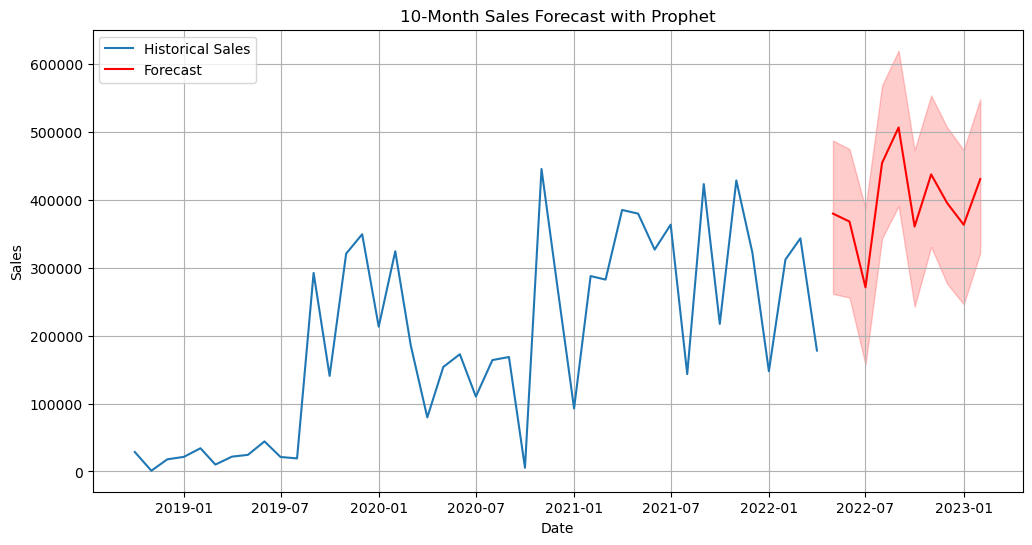

/var/folders/z6/_vn8cndd4x5dmx2cpjfdkjdr0000gn/T/ipykernel_31216/3376372498.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set_12["Sales_EUR"] = results["yhat"]


,Mapped_GCK,Sales_EUR
Month Year,,
2022-05-01,#12,379928.915839
2022-06-01,#12,368228.766251
2022-07-01,#12,271238.170275
2022-08-01,#12,454511.842683
2022-09-01,#12,506863.198814
2022-10-01,#12,360827.083442
2022-11-01,#12,437671.216400
2022-12-01,#12,395448.186021
2023-01-01,#12,363503.319180


In [ ]:
best_model, best_params, best_rmse, best_model_name = select_best_model(
    prophet_best_model_12, prophet_best_params_12, prophet_best_rmse_12, "Prophet",
    xgboost_best_model_12, xgboost_best_params_12, xgboost_best_rmse_12, "XGBoost"
    , sarima_best_model_12, sarima_best_params_12, sarima_best_rmse_12, "SARIMA"
)
print(f"Best Model: {best_model_name}")
print("Best Parameters:", best_params)
print("Best RMSE:", best_rmse)

if best_model_name == "XGBoost":
    results = xgboost_forecast(
        sales_agg12,
        df_market_12,
        period=10,
        params =best_params,
    )
elif best_model_name == "SARIMA":
    results = sarima_forecast(
        sales_agg12,
        period=10,
        params =best_params,
    )
else:
    results = prophet_forecast(
        sales_agg12,
        df_market_12,
        period=10,
        param =best_params,
    )
results.set_index('ds',inplace = True)
test_set_12.set_index('Month Year', inplace = True)
test_set_12["Sales_EUR"] = results["yhat"]
test_set_12

# Product 13

In [132]:
# selecte only the features that are selected in the feature selection step
test_set_13 = test_set[test_set['Mapped_GCK'] == '#13']
df_market_13 = df_market[selected_features_13]
df_market_13.head()

,PRI27840_org,WKLWEUR840_org_lag_3,RohiMETMIN1000_org_lag_4,PRO27276_org_lag_5,PRO27276_org_lag_3,RohCOPPER1000_org_lag_6,PRI27380_org_lag_4,MAB_ELE_PRO392_lag_4
date,,,,,,,,
2004-02-01,78.969864,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-03-01,79.673569,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-04-01,80.337639,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-05-01,80.798828,1.2646,NaN,NaN,85.913200,NaN,NaN,NaN
2004-06-01,80.913490,1.2262,48.747945,NaN,97.670815,NaN,93.020027,109.33401


## Xgboost

In [133]:
X_train, X_val, y_train, y_val = train_val_split(sales_agg13, df_market_13, train_size = 0.8)

X_val.info() 

xgboost_best_model_13, xgboost_best_params_13, xgboost_best_rmse_13 = model_evaluation_XGboost(X_train,
                                                                                             y_train, 
                                                                                             X_val, y_val, 
                                                                                             xgboost_param_grid)

print("Best Params:", xgboost_best_params_13)
print("Validation RMSE:", xgboost_best_rmse_13)

<class 'pandas.core.frame.DataFrame'>
Index: 9 entries, 2021-08-01 to 2022-04-01
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   PRI27840_org              9 non-null      float64
 1   WKLWEUR840_org_lag_3      9 non-null      float64
 2   RohiMETMIN1000_org_lag_4  9 non-null      float64
 3   PRO27276_org_lag_5        9 non-null      float64
 4   PRO27276_org_lag_3        9 non-null      float64
 5   RohCOPPER1000_org_lag_6   9 non-null      float64
 6   PRI27380_org_lag_4        9 non-null      float64
 7   MAB_ELE_PRO392_lag_4      9 non-null      float64
dtypes: float64(8)
memory usage: 648.0+ bytes
Params: {'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.5, 'colsample_bytree': 0.5, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 0} => RMSE: 11552.1225, Relative RMSE: 0.5107
Best Params: {'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.5, '

## Prophet

In [134]:
prophet_best_model_13, prophet_best_params_13, prophet_best_rmse_13 = model_evaluation_prophet(X_train,
                                                                                             y_train, 
                                                                                             X_val, 
                                                                                             y_val, 
                                                                                             prophet_param_grid)

print("Best Params:", prophet_best_params_13)

print("Validation RMSE:", prophet_best_rmse_13)

13:28:30 - cmdstanpy - INFO - Chain [1] start processing
13:28:30 - cmdstanpy - INFO - Chain [1] done processing


Params: {'seasonality_mode': 'additive', 'yearly_seasonality': True, 'seasonality_prior_scale': 0.01, 'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8} => RMSE: 11812.3245, Relative RMSE: 0.5222
Best Params: {'seasonality_mode': 'additive', 'yearly_seasonality': True, 'seasonality_prior_scale': 0.01, 'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8}
Validation RMSE: 11812.32446612715


## Sarima

In [ ]:
sarima_best_model_13, sarima_best_params_13, sarima_best_rmse_13 = model_evaluation_SARIMA(y_train, 
                                                             y_val, 
                                                             sarima_param_grid)

print("Best Params:", sarima_best_params_13)
print("Validation RMSE:", sarima_best_rmse_13)

## Final prediction 

Best Model: XGBoost
Best Parameters: {'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.5, 'colsample_bytree': 0.5, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 0}
Best RMSE: 11552.12254275763


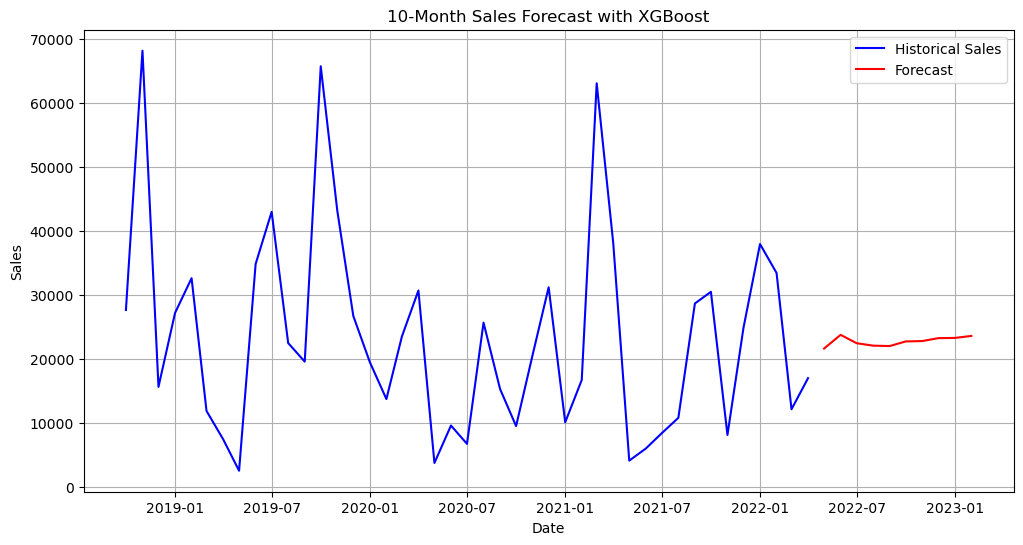

/var/folders/z6/_vn8cndd4x5dmx2cpjfdkjdr0000gn/T/ipykernel_31216/1861426354.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set_13["Sales_EUR"] = results["yhat"]


,Mapped_GCK,Sales_EUR
Month Year,,
2022-05-01,#13,21641.292969
2022-06-01,#13,23785.062500
2022-07-01,#13,22477.291016
2022-08-01,#13,22092.519531
2022-09-01,#13,22032.330078
2022-10-01,#13,22753.302734
2022-11-01,#13,22810.859375
2022-12-01,#13,23266.703125
2023-01-01,#13,23300.429688


In [ ]:
best_model, best_params, best_rmse, best_model_name = select_best_model(
    prophet_best_model_13, prophet_best_params_13, prophet_best_rmse_13, "Prophet",
    xgboost_best_model_13, xgboost_best_params_13, xgboost_best_rmse_13, "XGBoost"
    , sarima_best_model_13, sarima_best_params_13, sarima_best_rmse_13, "SARIMA"
)
print(f"Best Model: {best_model_name}")
print("Best Parameters:", best_params)
print("Best RMSE:", best_rmse)

if best_model_name == "XGBoost":
    results = xgboost_forecast(
        sales_agg13,
        df_market_13,
        period=10,
        params =best_params,
    )
elif best_model_name == "SARIMA":
    results = sarima_forecast(
        sales_agg13,
        period=10,
        params =best_params,
    )
else:
    results = prophet_forecast(
        sales_agg13,
        df_market_13,
        period=10,
        param =best_params,
    )
results.set_index('ds',inplace = True)
test_set_13.set_index('Month Year', inplace = True)
test_set_13["Sales_EUR"] = results["yhat"]
test_set_13

# Product 14

In [136]:
# selecte only the features that are selected in the feature selection step
test_set_14 = test_set[test_set['Mapped_GCK'] == '#14']
df_market_14 = df_market[selected_features_14]
df_market_14.head()

,MAB_ELE_SHP156,MAB_ELE_PRO826_lag_1,PRO27392_org,PRO27392_org_lag_2,MAB_ELE_PRO156_lag_5
date,,,,,
2004-02-01,16.940704,NaN,106.161262,NaN,NaN
2004-03-01,23.711852,111.353812,140.288741,NaN,NaN
2004-04-01,24.435235,127.558608,106.271197,106.161262,NaN
2004-05-01,23.708115,108.732297,101.608710,140.288741,NaN
2004-06-01,27.009138,110.645200,116.655248,106.271197,NaN


## Xgboost

In [137]:
X_train, X_val, y_train, y_val = train_val_split(sales_agg14, df_market_14, train_size = 0.8)

X_val.info() 

xgboost_best_model_14, xgboost_best_params_14, xgboost_best_rmse_14 = model_evaluation_XGboost(X_train,
                                                                                             y_train, 
                                                                                             X_val, y_val, 
                                                                                             xgboost_param_grid)

print("Best Params:", xgboost_best_params_14)
print("Validation RMSE:", xgboost_best_rmse_14)

<class 'pandas.core.frame.DataFrame'>
Index: 9 entries, 2021-08-01 to 2022-04-01
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   MAB_ELE_SHP156        9 non-null      float64
 1   MAB_ELE_PRO826_lag_1  9 non-null      float64
 2   PRO27392_org          9 non-null      float64
 3   PRO27392_org_lag_2    9 non-null      float64
 4   MAB_ELE_PRO156_lag_5  9 non-null      float64
dtypes: float64(5)
memory usage: 432.0+ bytes
Params: {'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.5, 'colsample_bytree': 0.5, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 0} => RMSE: 14058.3662, Relative RMSE: 1.3385
Best Params: {'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.5, 'colsample_bytree': 0.5, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 0}
Validation RMSE: 14058.366208652445


## Prophet

In [138]:
prophet_best_model_14, prophet_best_params_14, prophet_best_rmse_14 = model_evaluation_prophet(X_train,
                                                                                             y_train, 
                                                                                             X_val, 
                                                                                             y_val, 
                                                                                             prophet_param_grid)

print("Best Params:", prophet_best_params_14)

print("Validation RMSE:", prophet_best_rmse_14)

13:28:30 - cmdstanpy - INFO - Chain [1] start processing
13:28:30 - cmdstanpy - INFO - Chain [1] done processing


Params: {'seasonality_mode': 'additive', 'yearly_seasonality': True, 'seasonality_prior_scale': 0.01, 'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8} => RMSE: 14453.6590, Relative RMSE: 1.3761
Best Params: {'seasonality_mode': 'additive', 'yearly_seasonality': True, 'seasonality_prior_scale': 0.01, 'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8}
Validation RMSE: 14453.659012953369


## Sarima

In [ ]:
sarima_best_model_14, sarima_best_params_14, sarima_best_rmse_14 = model_evaluation_SARIMA(y_train, 
                                                             y_val, 
                                                             sarima_param_grid)

print("Best Params:", sarima_best_params_14)
print("Validation RMSE:", sarima_best_rmse_14)

## Final prediction 

Best Model: XGBoost
Best Parameters: {'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.5, 'colsample_bytree': 0.5, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 0}
Best RMSE: 14058.366208652445


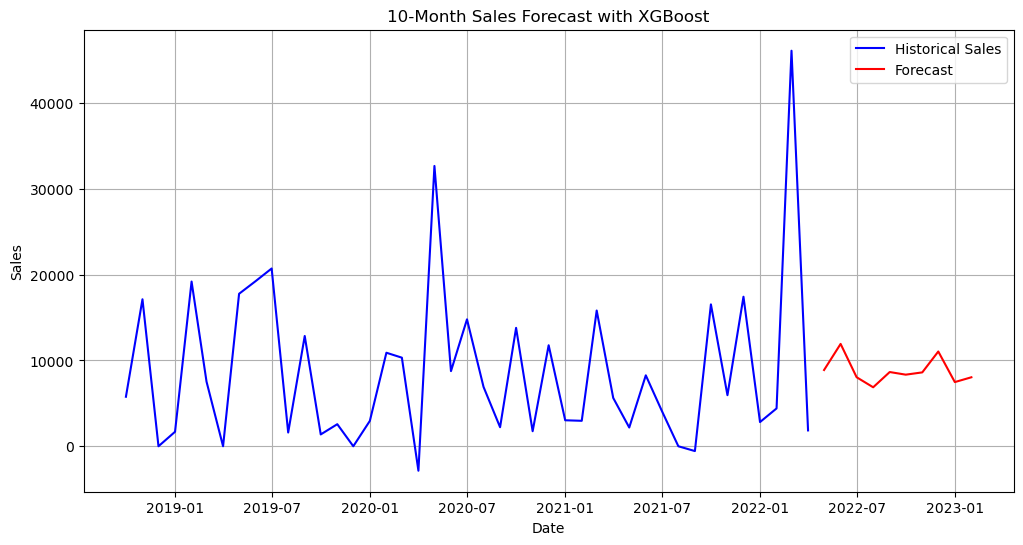

/var/folders/z6/_vn8cndd4x5dmx2cpjfdkjdr0000gn/T/ipykernel_31216/28306033.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set_14["Sales_EUR"] = results["yhat"]


,Mapped_GCK,Sales_EUR
Month Year,,
2022-05-01,#14,8885.852539
2022-06-01,#14,11929.567383
2022-07-01,#14,8044.973145
2022-08-01,#14,6873.994629
2022-09-01,#14,8650.729492
2022-10-01,#14,8344.379883
2022-11-01,#14,8609.995117
2022-12-01,#14,11043.991211
2023-01-01,#14,7480.463867


In [ ]:
best_model, best_params, best_rmse, best_model_name = select_best_model(
    prophet_best_model_14, prophet_best_params_14, prophet_best_rmse_14, "Prophet",
    xgboost_best_model_14, xgboost_best_params_14, xgboost_best_rmse_14, "XGBoost"
    , sarima_best_model_14, sarima_best_params_14, sarima_best_rmse_14, "SARIMA"
)
print(f"Best Model: {best_model_name}")
print("Best Parameters:", best_params)
print("Best RMSE:", best_rmse)

if best_model_name == "XGBoost":
    results = xgboost_forecast(
        sales_agg14,
        df_market_14,
        period=10,
        params =best_params,
    )
elif best_model_name == "SARIMA":
    results = sarima_forecast(
        sales_agg14,
        period=10,
        params =best_params,
    )
else:
    results = prophet_forecast(
        sales_agg14,
        df_market_14,
        period=10,
        param =best_params,
    )
results.set_index('ds',inplace = True)
test_set_14.set_index('Month Year', inplace = True)
test_set_14["Sales_EUR"] = results["yhat"]
test_set_14

# Product 16

In [140]:
# selecte only the features that are selected in the feature selection step
test_set_16 = test_set[test_set['Mapped_GCK'] == '#16']
df_market_16 = df_market[selected_features_16]
df_market_16.head()

,MAB_ELE_PRO756_lag_5,RohiMETMIN1000_org,PRI27840_org,PRI27276_org,RohCOPPER1000_org,MAB_ELE_PRO156_lag_5,MAB_ELE_SHP250_lag_1
date,,,,,,,
2004-02-01,NaN,48.747945,78.969864,93.230453,36.623832,NaN,NaN
2004-03-01,NaN,49.256157,79.673569,93.335678,39.931055,NaN,83.458866
2004-04-01,NaN,49.423751,80.337639,93.440903,39.134854,NaN,106.168192
2004-05-01,NaN,46.468392,80.798828,93.546127,36.278433,NaN,92.007646
2004-06-01,NaN,47.803913,80.913490,93.440903,35.657380,NaN,85.696486


## Xgboost

In [141]:
X_train, X_val, y_train, y_val = train_val_split(sales_agg16, df_market_16, train_size = 0.8)

X_val.info() 

xgboost_best_model_16, xgboost_best_params_16, xgboost_best_rmse_16 = model_evaluation_XGboost(X_train,
                                                                                             y_train, 
                                                                                             X_val, y_val, 
                                                                                             xgboost_param_grid)

print("Best Params:", xgboost_best_params_16)
print("Validation RMSE:", xgboost_best_rmse_16)

<class 'pandas.core.frame.DataFrame'>
Index: 9 entries, 2021-08-01 to 2022-04-01
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   MAB_ELE_PRO756_lag_5  9 non-null      float64
 1   RohiMETMIN1000_org    9 non-null      float64
 2   PRI27840_org          9 non-null      float64
 3   PRI27276_org          9 non-null      float64
 4   RohCOPPER1000_org     9 non-null      float64
 5   MAB_ELE_PRO156_lag_5  9 non-null      float64
 6   MAB_ELE_SHP250_lag_1  9 non-null      float64
dtypes: float64(7)
memory usage: 576.0+ bytes
Params: {'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.5, 'colsample_bytree': 0.5, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 0} => RMSE: 167525.1728, Relative RMSE: 0.9907
Best Params: {'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.5, 'colsample_bytree': 0.5, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 0}
Validation RMSE: 1675

## Prophet

In [142]:
prophet_best_model_16, prophet_best_params_16, prophet_best_rmse_16 = model_evaluation_prophet(X_train,
                                                                                             y_train, 
                                                                                             X_val, 
                                                                                             y_val, 
                                                                                             prophet_param_grid)

print("Best Params:", prophet_best_params_16)

print("Validation RMSE:", prophet_best_rmse_16)

13:28:31 - cmdstanpy - INFO - Chain [1] start processing
13:28:31 - cmdstanpy - INFO - Chain [1] done processing


Params: {'seasonality_mode': 'additive', 'yearly_seasonality': True, 'seasonality_prior_scale': 0.01, 'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8} => RMSE: 205375.4545, Relative RMSE: 1.2145
Best Params: {'seasonality_mode': 'additive', 'yearly_seasonality': True, 'seasonality_prior_scale': 0.01, 'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8}
Validation RMSE: 205375.45447760748


## Sarima

In [ ]:
sarima_best_model_16, sarima_best_params_16, sarima_best_rmse_16 = model_evaluation_SARIMA(y_train, 
                                                             y_val, 
                                                             sarima_param_grid)

print("Best Params:", sarima_best_params_16)
print("Validation RMSE:", sarima_best_rmse_16)

## Final prediction 

Best Model: XGBoost
Best Parameters: {'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.5, 'colsample_bytree': 0.5, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 0}
Best RMSE: 167525.172845994


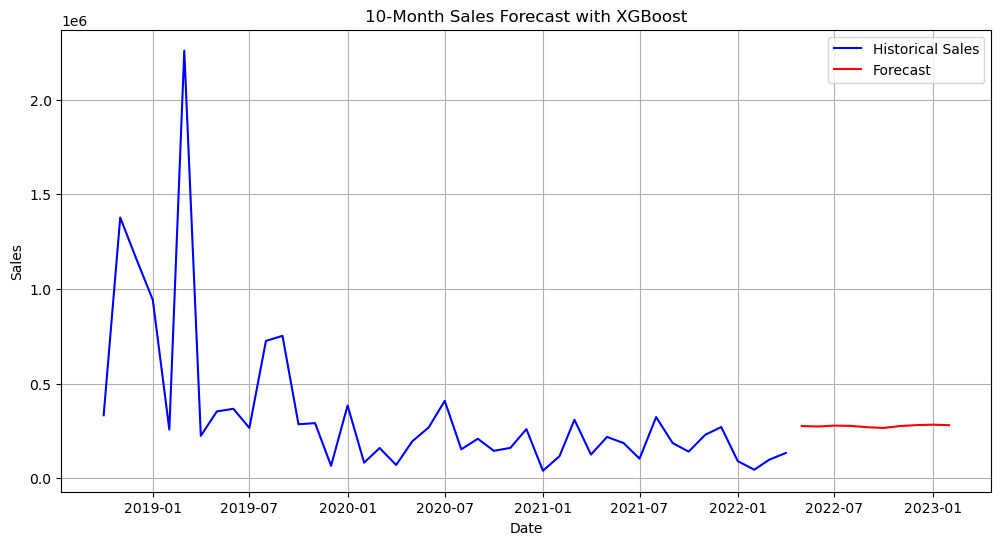

/var/folders/z6/_vn8cndd4x5dmx2cpjfdkjdr0000gn/T/ipykernel_31216/2858692681.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set_16["Sales_EUR"] = results["yhat"]


,Mapped_GCK,Sales_EUR
Month Year,,
2022-05-01,#16,276322.25000
2022-06-01,#16,273830.21875
2022-07-01,#16,278664.90625
2022-08-01,#16,277087.03125
2022-09-01,#16,270040.03125
2022-10-01,#16,266140.90625
2022-11-01,#16,276103.12500
2022-12-01,#16,281109.03125
2023-01-01,#16,283522.56250


In [ ]:
best_model, best_params, best_rmse, best_model_name = select_best_model(
    prophet_best_model_16, prophet_best_params_16, prophet_best_rmse_16, "Prophet",
    xgboost_best_model_16, xgboost_best_params_16, xgboost_best_rmse_16, "XGBoost"
    , sarima_best_model_16, sarima_best_params_16, sarima_best_rmse_16, "SARIMA"
)
print(f"Best Model: {best_model_name}")
print("Best Parameters:", best_params)
print("Best RMSE:", best_rmse)

if best_model_name == "XGBoost":
    results = xgboost_forecast(
        sales_agg16,
        df_market_16,
        period=10,
        params =best_params,
    )
elif best_model_name == "SARIMA":
    results = sarima_forecast(
        sales_agg16,
        period=10,
        params =best_params,
    )
else:
    results = prophet_forecast(
        sales_agg16,
        df_market_16,
        period=10,
        param =best_params,
    )
results.set_index('ds',inplace = True)
test_set_16.set_index('Month Year', inplace = True)
test_set_16["Sales_EUR"] = results["yhat"]
test_set_16

# Product 20

In [144]:
# selecte only the features that are selected in the feature selection step
test_set_20 = test_set[test_set['Mapped_GCK'] == '#20']
df_market_20 = df_market[selected_features_20]
df_market_20.head()

,PRO27826_org_lag_1,MAB_ELE_PRO156_lag_3,PRO27826_org_lag_4,PRO27276_org,PRO271000_org_lag_5,PRO27826_org_lag_5,PRO27826_org_lag_6,WKLWEUR840_org_lag_3
date,,,,,,,,
2004-02-01,NaN,NaN,NaN,85.913200,NaN,NaN,NaN,NaN
2004-03-01,120.706516,NaN,NaN,97.670815,NaN,NaN,NaN,NaN
2004-04-01,138.309550,NaN,NaN,87.253983,NaN,NaN,NaN,NaN
2004-05-01,115.557330,16.940704,NaN,84.675552,NaN,NaN,NaN,1.2646
2004-06-01,119.269534,23.711852,120.706516,95.401802,NaN,NaN,NaN,1.2262


## Xgboost

In [145]:
X_train, X_val, y_train, y_val = train_val_split(sales_agg20, df_market_20, train_size = 0.8)

X_val.info() 

xgboost_best_model_20, xgboost_best_params_20, xgboost_best_rmse_20 = model_evaluation_XGboost(X_train,
                                                                                             y_train, 
                                                                                             X_val, y_val, 
                                                                                             xgboost_param_grid)

print("Best Params:", xgboost_best_params_20)
print("Validation RMSE:", xgboost_best_rmse_20)


<class 'pandas.core.frame.DataFrame'>
Index: 9 entries, 2021-08-01 to 2022-04-01
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   PRO27826_org_lag_1    9 non-null      float64
 1   MAB_ELE_PRO156_lag_3  9 non-null      float64
 2   PRO27826_org_lag_4    9 non-null      float64
 3   PRO27276_org          9 non-null      float64
 4   PRO271000_org_lag_5   9 non-null      float64
 5   PRO27826_org_lag_5    9 non-null      float64
 6   PRO27826_org_lag_6    9 non-null      float64
 7   WKLWEUR840_org_lag_3  9 non-null      float64
dtypes: float64(8)
memory usage: 648.0+ bytes
Params: {'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.5, 'colsample_bytree': 0.5, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 0} => RMSE: 1886.2964, Relative RMSE: 1.4933
Best Params: {'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.5, 'colsample_bytree': 0.5, 'gamma': 0, 'reg_

## Prophet

In [146]:
prophet_best_model_20, prophet_best_params_20, prophet_best_rmse_20 = model_evaluation_prophet(X_train,
                                                                                             y_train, 
                                                                                             X_val, 
                                                                                             y_val, 
                                                                                             prophet_param_grid)

print("Best Params:", prophet_best_params_20)

print("Validation RMSE:", prophet_best_rmse_20)

13:28:31 - cmdstanpy - INFO - Chain [1] start processing
13:28:31 - cmdstanpy - INFO - Chain [1] done processing


Params: {'seasonality_mode': 'additive', 'yearly_seasonality': True, 'seasonality_prior_scale': 0.01, 'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8} => RMSE: 2198.8811, Relative RMSE: 1.7407
Best Params: {'seasonality_mode': 'additive', 'yearly_seasonality': True, 'seasonality_prior_scale': 0.01, 'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8}
Validation RMSE: 2198.88113512418


## Sarima

In [ ]:
sarima_best_model_20, sarima_best_params_20, sarima_best_rmse_20 = model_evaluation_SARIMA(y_train, 
                                                             y_val, 
                                                             sarima_param_grid)

print("Best Params:", sarima_best_params_20)
print("Validation RMSE:", sarima_best_rmse_20)

## Final prediction

Best Model: XGBoost
Best Parameters: {'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.5, 'colsample_bytree': 0.5, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 0}
Best RMSE: 1886.2963972716734


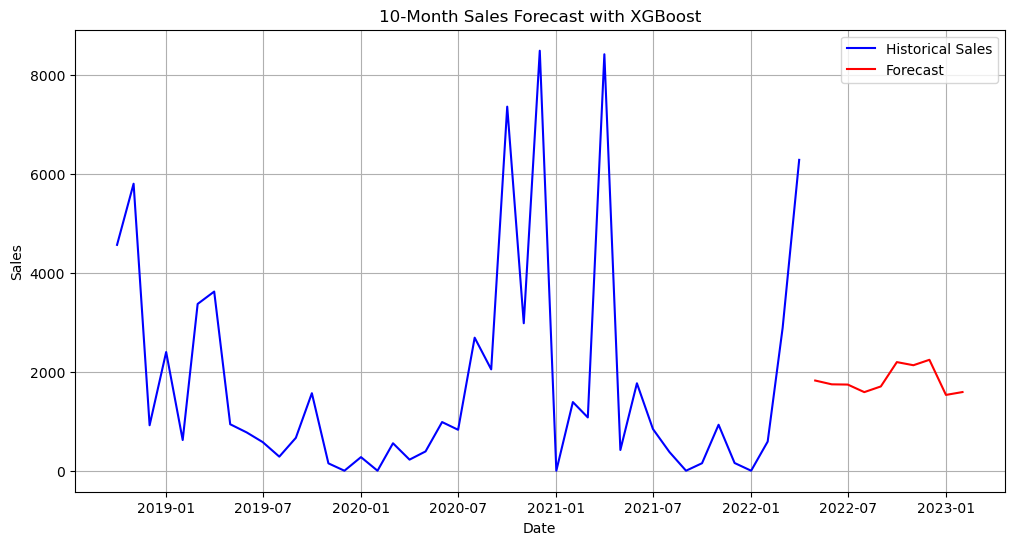

/var/folders/z6/_vn8cndd4x5dmx2cpjfdkjdr0000gn/T/ipykernel_31216/1813230694.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set_20["Sales_EUR"] = results["yhat"]


,Mapped_GCK,Sales_EUR
Month Year,,
2022-05-01,#20,1822.258667
2022-06-01,#20,1745.421997
2022-07-01,#20,1740.641357
2022-08-01,#20,1587.875122
2022-09-01,#20,1702.899048
2022-10-01,#20,2194.496338
2022-11-01,#20,2131.344727
2022-12-01,#20,2241.023193
2023-01-01,#20,1531.580688


In [ ]:
best_model, best_params, best_rmse, best_model_name = select_best_model(
    prophet_best_model_20, prophet_best_params_20, prophet_best_rmse_20, "Prophet",
    xgboost_best_model_20, xgboost_best_params_20, xgboost_best_rmse_20, "XGBoost"
    , sarima_best_model_20, sarima_best_params_20, sarima_best_rmse_20, "SARIMA"
)
print(f"Best Model: {best_model_name}")
print("Best Parameters:", best_params)
print("Best RMSE:", best_rmse)

if best_model_name == "XGBoost":
    results = xgboost_forecast(
        sales_agg20,
        df_market_20,
        period=10,
        params =best_params,
    )
elif best_model_name == "SARIMA":
    results = sarima_forecast(
        sales_agg20,
        period=10,
        params =best_params,
    )
else:
    results = prophet_forecast(
        sales_agg20,
        df_market_20,
        period=10,
        param =best_params,
    )
results.set_index('ds',inplace = True)
test_set_20.set_index('Month Year', inplace = True)
test_set_20["Sales_EUR"] = results["yhat"]
test_set_20

# Product 36

In [148]:
# selecte only the features that are selected in the feature selection step
test_set_36 = test_set[test_set['Mapped_GCK'] == '#36']
df_market_36 = df_market[selected_features_36]
df_market_36.head()

,PRO27392_org_lag_1,MAB_ELE_SHP392_lag_6,MAB_ELE_SHP250_lag_5
date,,,
2004-02-01,NaN,NaN,NaN
2004-03-01,106.161262,NaN,NaN
2004-04-01,140.288741,NaN,NaN
2004-05-01,106.271197,NaN,NaN
2004-06-01,101.608710,NaN,NaN


## Xgboost

In [149]:
X_train, X_val, y_train, y_val = train_val_split(sales_agg36, df_market_36, train_size = 0.8)

X_val.info() 

xgboost_best_model_36, xgboost_best_params_36, xgboost_best_rmse_36 = model_evaluation_XGboost(X_train,
                                                                                             y_train, 
                                                                                             X_val, y_val, 
                                                                                             xgboost_param_grid)

print("Best Params:", xgboost_best_params_36)
print("Validation RMSE:", xgboost_best_rmse_36)


<class 'pandas.core.frame.DataFrame'>
Index: 9 entries, 2021-08-01 to 2022-04-01
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   PRO27392_org_lag_1    9 non-null      float64
 1   MAB_ELE_SHP392_lag_6  9 non-null      float64
 2   MAB_ELE_SHP250_lag_5  9 non-null      float64
dtypes: float64(3)
memory usage: 288.0+ bytes
Params: {'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.5, 'colsample_bytree': 0.5, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 0} => RMSE: 20319.5243, Relative RMSE: 1.2510
Best Params: {'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.5, 'colsample_bytree': 0.5, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 0}
Validation RMSE: 20319.524263594772


## Prophet

In [150]:
prophet_best_model_36, prophet_best_params_36, prophet_best_rmse_36 = model_evaluation_prophet(X_train,
                                                                                             y_train, 
                                                                                             X_val, 
                                                                                             y_val, 
                                                                                             prophet_param_grid)

print("Best Params:", prophet_best_params_36)

print("Validation RMSE:", prophet_best_rmse_36)

13:28:31 - cmdstanpy - INFO - Chain [1] start processing
13:28:32 - cmdstanpy - INFO - Chain [1] done processing


Params: {'seasonality_mode': 'additive', 'yearly_seasonality': True, 'seasonality_prior_scale': 0.01, 'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8} => RMSE: 24352.6499, Relative RMSE: 1.4993
Best Params: {'seasonality_mode': 'additive', 'yearly_seasonality': True, 'seasonality_prior_scale': 0.01, 'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8}
Validation RMSE: 24352.649905257076


## Sarima

In [ ]:
sarima_best_model_36, sarima_best_params_36, sarima_best_rmse_36 = model_evaluation_SARIMA(y_train, 
                                                             y_val, 
                                                             sarima_param_grid)

print("Best Params:", sarima_best_params_36)
print("Validation RMSE:", sarima_best_rmse_36)

## Final prediction

Best Model: XGBoost
Best Parameters: {'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.5, 'colsample_bytree': 0.5, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 0}
Best RMSE: 20319.524263594772


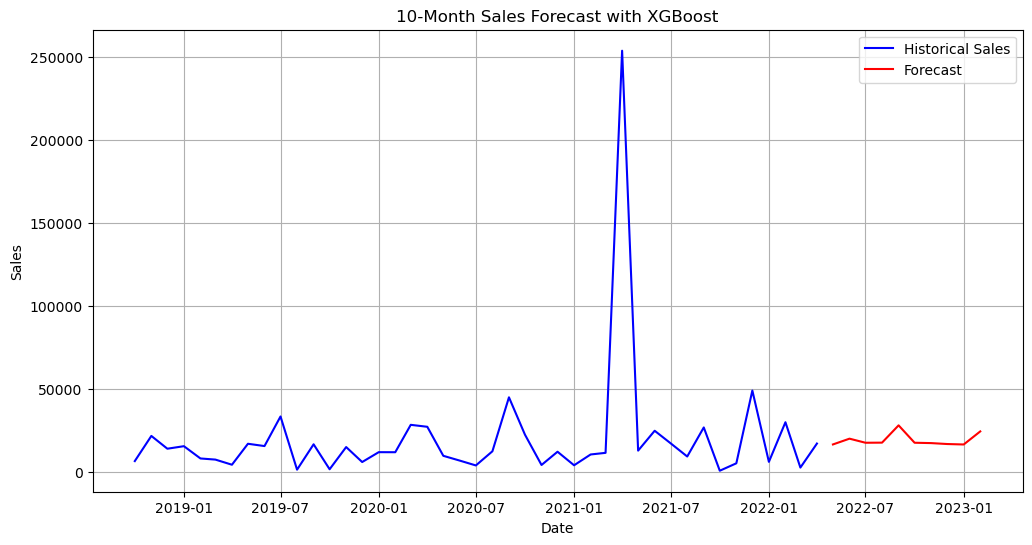

/var/folders/z6/_vn8cndd4x5dmx2cpjfdkjdr0000gn/T/ipykernel_31216/3636348925.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set_36["Sales_EUR"] = results["yhat"]


,Mapped_GCK,Sales_EUR
Month Year,,
2022-05-01,#36,16492.648438
2022-06-01,#36,19969.105469
2022-07-01,#36,17511.126953
2022-08-01,#36,17580.552734
2022-09-01,#36,27987.568359
2022-10-01,#36,17515.767578
2022-11-01,#36,17302.130859
2022-12-01,#36,16745.539062
2023-01-01,#36,16468.824219


In [ ]:
best_model, best_params, best_rmse, best_model_name = select_best_model(
    prophet_best_model_36, prophet_best_params_36, prophet_best_rmse_36, "Prophet",
    xgboost_best_model_36, xgboost_best_params_36, xgboost_best_rmse_36, "XGBoost"
    , sarima_best_model_36, sarima_best_params_36, sarima_best_rmse_36, "SARIMA"
)
print(f"Best Model: {best_model_name}")
print("Best Parameters:", best_params)
print("Best RMSE:", best_rmse)

if best_model_name == "XGBoost":
    results = xgboost_forecast(
        sales_agg36,
        df_market_36,
        period=10,
        params =best_params,
    )
elif best_model_name == "SARIMA":
    results = sarima_forecast(
        sales_agg36,
        period=10,
        params =best_params,
    )
else:
    results = prophet_forecast(
        sales_agg36,
        df_market_36,
        period=10,
        param =best_params,
    )
results.set_index('ds',inplace = True)
test_set_36.set_index('Month Year', inplace = True)
test_set_36["Sales_EUR"] = results["yhat"]
test_set_36

<hr>
<a class="anchor" id="export">

 ## 3. Export
 </a>

In [152]:
test_set_1 = test_set_1.reset_index()
test_set_3 = test_set_3.reset_index()
test_set_4 = test_set_4.reset_index()
test_set_5 = test_set_5.reset_index()
test_set_6 = test_set_6.reset_index()
test_set_8 = test_set_8.reset_index()
test_set_9 = test_set_9.reset_index()
test_set_11 = test_set_11.reset_index()
test_set_12 = test_set_12.reset_index()
test_set_13 = test_set_13.reset_index()
test_set_14 = test_set_14.reset_index()
test_set_16 = test_set_16.reset_index()
test_set_20 = test_set_20.reset_index()
test_set_36 = test_set_36.reset_index()

test_set = pd.concat([test_set_1, test_set_3, test_set_4, test_set_5, test_set_6, test_set_8, test_set_9,
                     test_set_11, test_set_12, test_set_13, test_set_14, test_set_16, test_set_20, test_set_36])
test_set



,Month Year,Mapped_GCK,Sales_EUR
0,2022-05-01,#1,3.745629e+07
1,2022-06-01,#1,3.725462e+07
2,2022-07-01,#1,3.710173e+07
3,2022-08-01,#1,3.717736e+07
4,2022-09-01,#1,3.718212e+07
...,...,...,...
5,2022-10-01,#36,1.751577e+04
6,2022-11-01,#36,1.730213e+04
7,2022-12-01,#36,1.674554e+04
8,2023-01-01,#36,1.646882e+04


In [153]:
def revert_month_year(date_obj):
    reverse_month_map = {
        1: "Jan",
        2: "Feb",
        3: "Mar",
        4: "Apr",
        5: "Mai",
        6: "Jun",
        7: "Jul",
        8: "Aug",
        9: "Sep",
        10: "Okt",
        11: "Nov",
        12: "Dez"
    }
    # Format as e.g. "Jan20" (adjust the format if a space is needed)
    return f"{reverse_month_map[date_obj.month]} {date_obj.strftime('%y')}"

# Revert the conversion on the 'Month Year' column
test_set['Month Year'] = test_set['Month Year'].apply(revert_month_year)

test_set.to_csv('../data/test_set_predicted.csv', index=False)